In [1]:
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier

In [2]:
param_dist = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'min_child_samples': [10, 20, 30]
}

In [3]:
pd.set_option('display.max_rows', None)

In [4]:
import os
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
from sklearn.preprocessing import label_binarize

def train_phase(phase_path, param_dist, n_iter=10, random_state=42, sample=False):
    best_model = None
    best_score = 0
    all_metrics = []
    best_params = None

    for fold in range(1, 6):
        fold_path = os.path.join(phase_path, f"fold{fold}")
        scaler = joblib.load(f"{fold_path}/scaler.pkl")
        
        if sample:
            X_train = pd.read_csv(f"{fold_path}/X_train_resampled.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train_resampled.csv").values.ravel()
            X_train_scaled = X_train
        else:
            X_train = pd.read_csv(f"{fold_path}/X_train.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train.csv").values.ravel()
            X_train_scaled = scaler.transform(X_train)
            X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
        
        X_val = pd.read_csv(f"{fold_path}/X_val.csv")
        y_val = pd.read_csv(f"{fold_path}/y_val.csv").values.ravel()
        X_val_scaled = scaler.transform(X_val)
        X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_train.columns)

        # Hyperparameter tuning on fold 1
        if fold == 1:
            clf = LGBMClassifier(random_state=random_state)
            search = RandomizedSearchCV(
                clf,
                param_distributions=param_dist,
                n_iter=n_iter,
                cv=3,
                n_jobs=-1,
                verbose=1,
                scoring='f1_macro'
            )
            search.fit(X_train_scaled, y_train)
            best_params = search.best_params_
            print(f"[Fold 1] Best Parameters Found: {best_params}")

        model = LGBMClassifier(**best_params, random_state=random_state)
        model.fit(X_train_scaled, y_train)

        y_pred = model.predict(X_val_scaled)
        y_proba = model.predict_proba(X_val_scaled)

        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='macro')

        # Compute multiclass AUC
        classes = model.classes_
        y_val_bin = label_binarize(y_val, classes=classes)
        auc = roc_auc_score(y_val_bin, y_proba, average='macro', multi_class='ovr')

        all_metrics.append({'fold': fold, 'accuracy': acc, 'f1_macro': f1, 'auc': auc})

        if f1 > best_score:
            best_score = f1
            best_model = model
            best_scaler = scaler
            best_fold = fold

        print(f"\nFold {fold} Classification Report:\n", classification_report(y_val, y_pred))

        # Confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - Fold {fold}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        # Plot ROC Curve per class
        plt.figure(figsize=(8, 6))
        for i, cls in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_proba[:, i])
            plt.plot(fpr, tpr, label=f'Class {cls}')
        plt.plot([0, 1], [0, 1], 'k--', label='Chance')
        plt.title(f'ROC Curve - Fold {fold}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Print averages
    avg_metrics = pd.DataFrame(all_metrics).mean().to_dict()
    print(f"\nAverage Accuracy: {avg_metrics['accuracy']:.4f}")
    print(f"Average F1 Macro: {avg_metrics['f1_macro']:.4f}")
    print(f"Average AUC: {avg_metrics['auc']:.4f}")

    # Feature importance
    feature_importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
    feature_importances = feature_importances.sort_values(ascending=False)
    print("\nTop Feature Importances:")
    print(feature_importances.head(10))

    return best_model, best_scaler, best_fold, all_metrics



=== Training Phase 1 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.159916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3397
[LightGBM] [Info] Number of data points in the train set: 7237, number of used features: 35
[LightGBM] [Info] Start training from score -0.418749
[LightGBM] [Info] Start training from score -1.504216
[LightGBM] [Info] Start training from score -2.353173
[LightGBM] [Info] Start training from score -3.830716
[LightGBM] [Info] Start training from score -5.751468
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

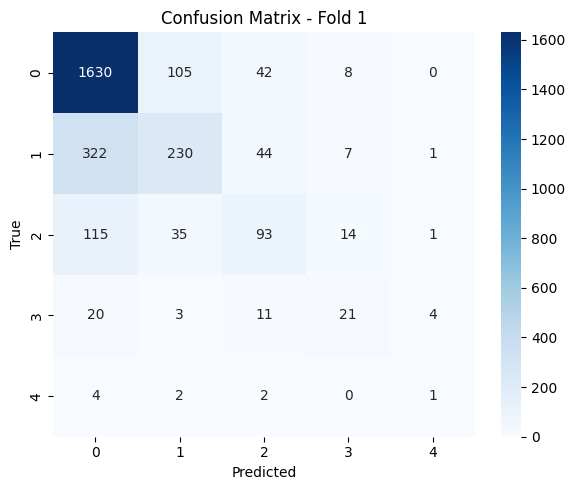

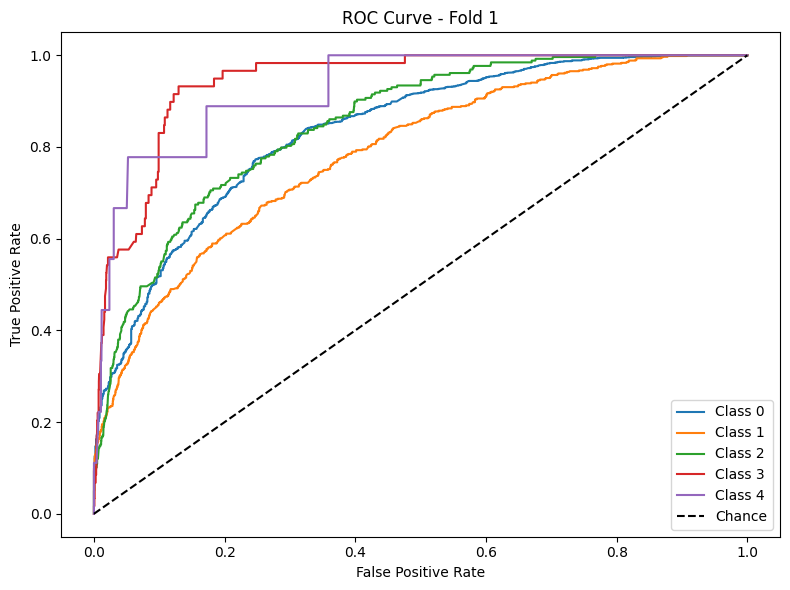

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3753
[LightGBM] [Info] Number of data points in the train set: 10857, number of used features: 36
[LightGBM] [Info] Start training from score -0.418957
[LightGBM] [Info] Start training from score -1.503939
[LightGBM] [Info] Start training from score -2.353311
[LightGBM] [Info] Start training from score -3.828734
[LightGBM] [Info] Start training from score -5.737217
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

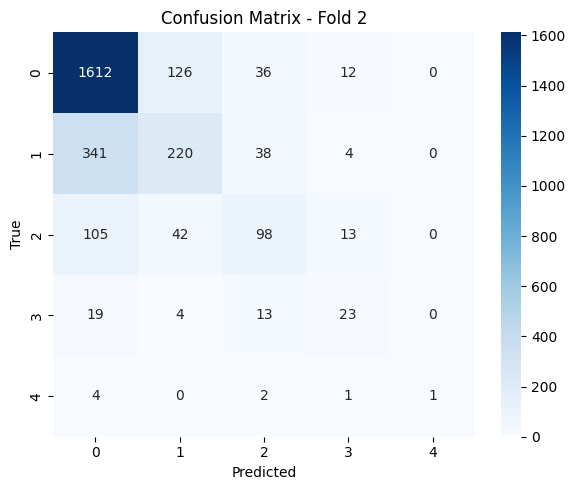

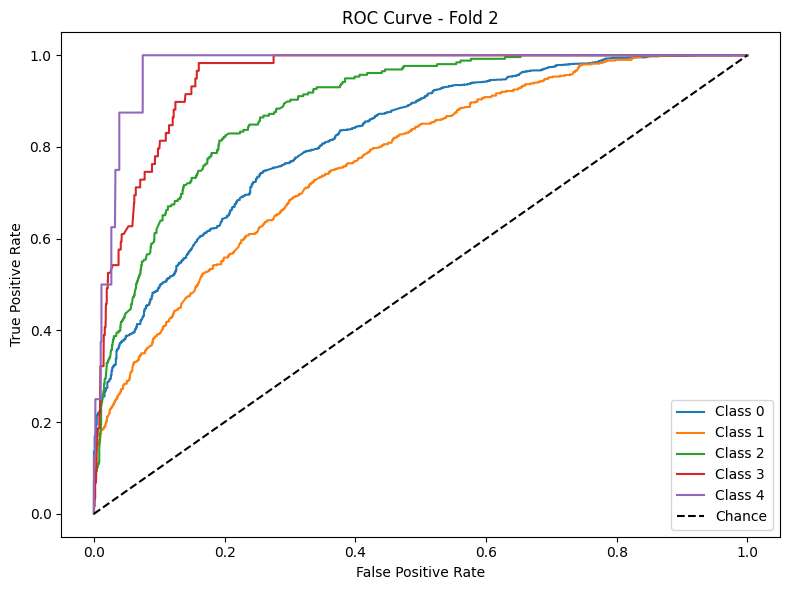

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3724
[LightGBM] [Info] Number of data points in the train set: 10857, number of used features: 36
[LightGBM] [Info] Start training from score -0.418957
[LightGBM] [Info] Start training from score -1.503939
[LightGBM] [Info] Start training from score -2.353311
[LightGBM] [Info] Start training from score -3.828734
[LightGBM] [Info] Start training from score -5.737217
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

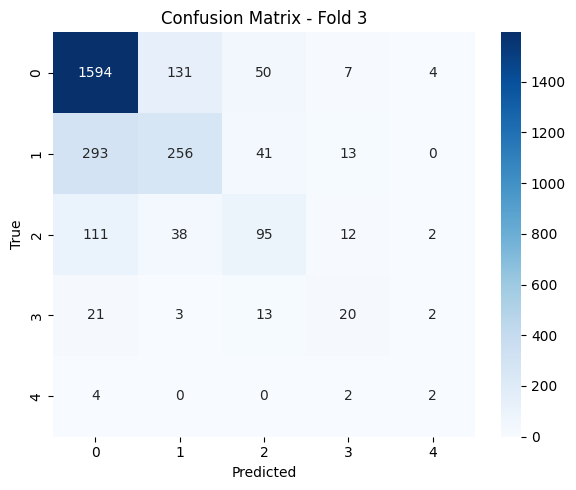

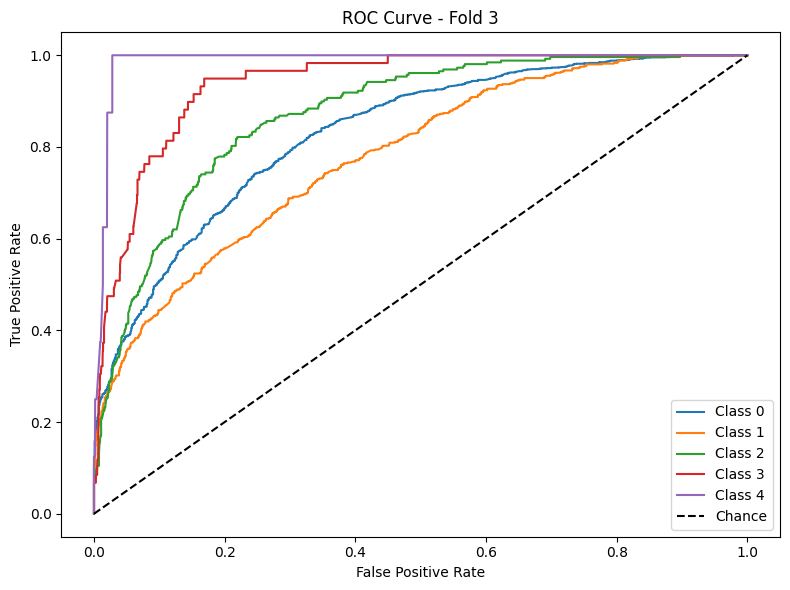

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3700
[LightGBM] [Info] Number of data points in the train set: 10857, number of used features: 36
[LightGBM] [Info] Start training from score -0.418817
[LightGBM] [Info] Start training from score -1.503939
[LightGBM] [Info] Start training from score -2.353311
[LightGBM] [Info] Start training from score -3.828734
[LightGBM] [Info] Start training from score -5.766205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

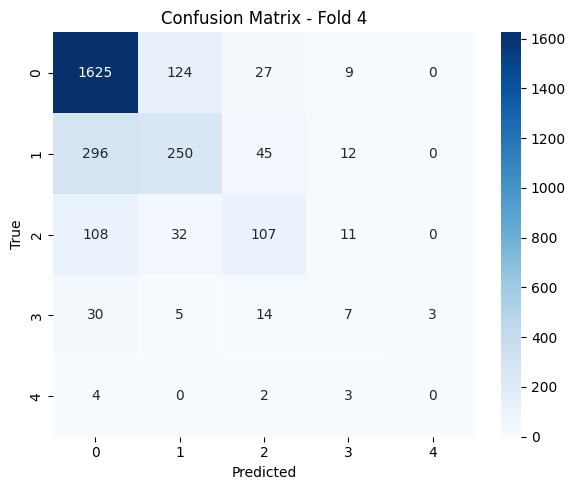

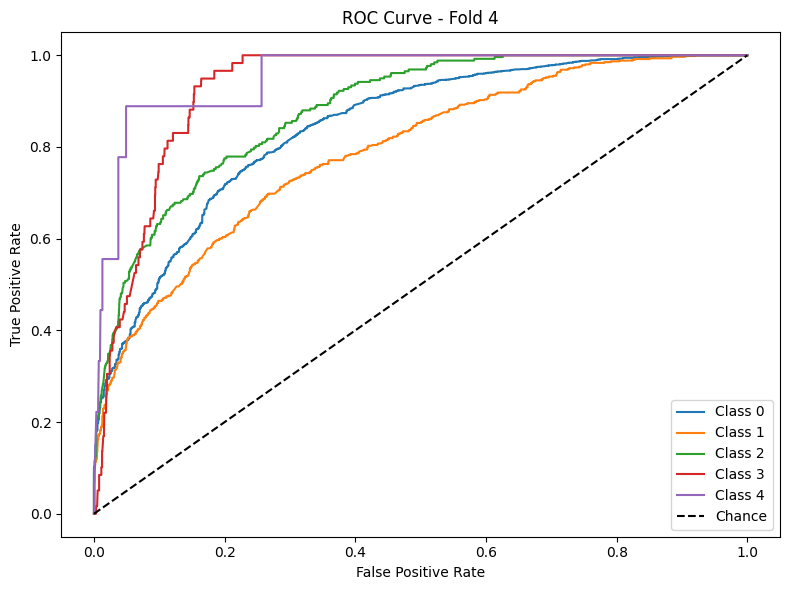

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3723
[LightGBM] [Info] Number of data points in the train set: 10857, number of used features: 36
[LightGBM] [Info] Start training from score -0.418817
[LightGBM] [Info] Start training from score -1.503939
[LightGBM] [Info] Start training from score -2.353311
[LightGBM] [Info] Start training from score -3.828734
[LightGBM] [Info] Start training from score -5.766205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

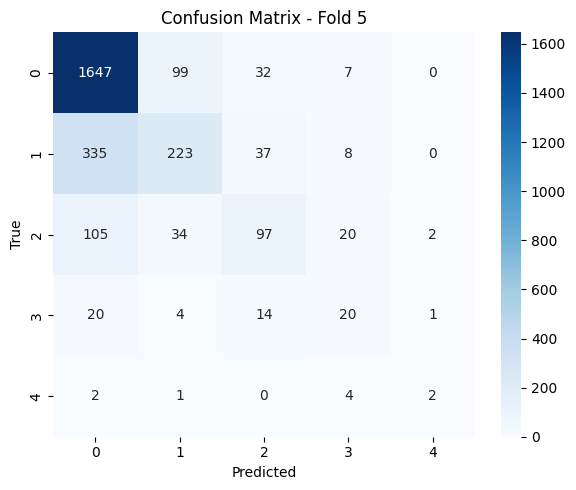

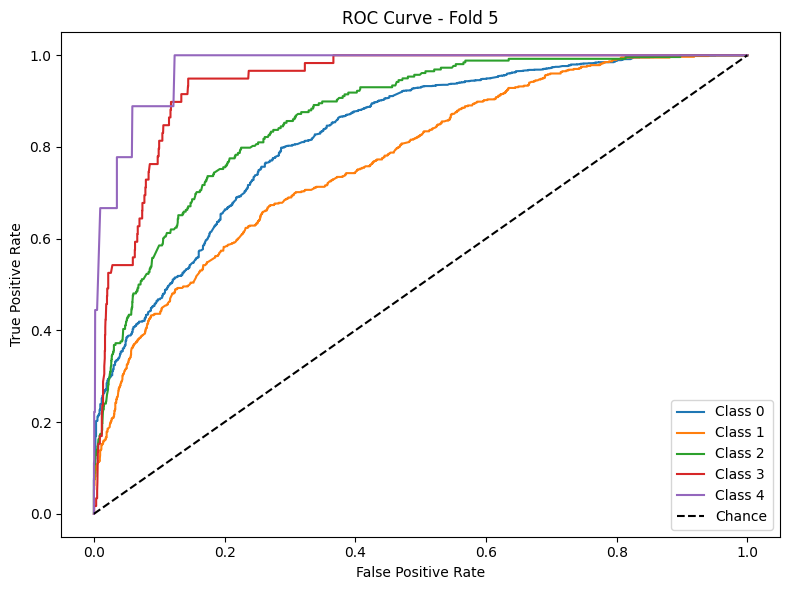


Average Accuracy: 0.7276
Average F1 Macro: 0.4494
Average AUC: 0.8772

Top Feature Importances:
remaining_time                 16464
cluster                        10678
total_words_phase1              7260
eigenvector                     4450
degree                          3623
school                          3194
user_month                      2259
closeness                       2171
total_neutral1                  2129
entropy_time_comment_phase1     1850
dtype: int32

=== Training Phase 2 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

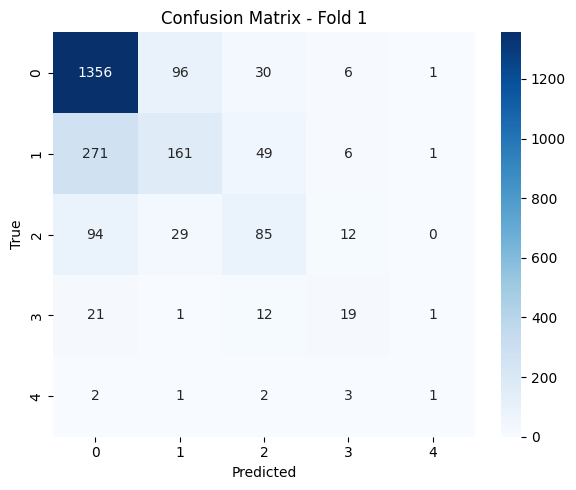

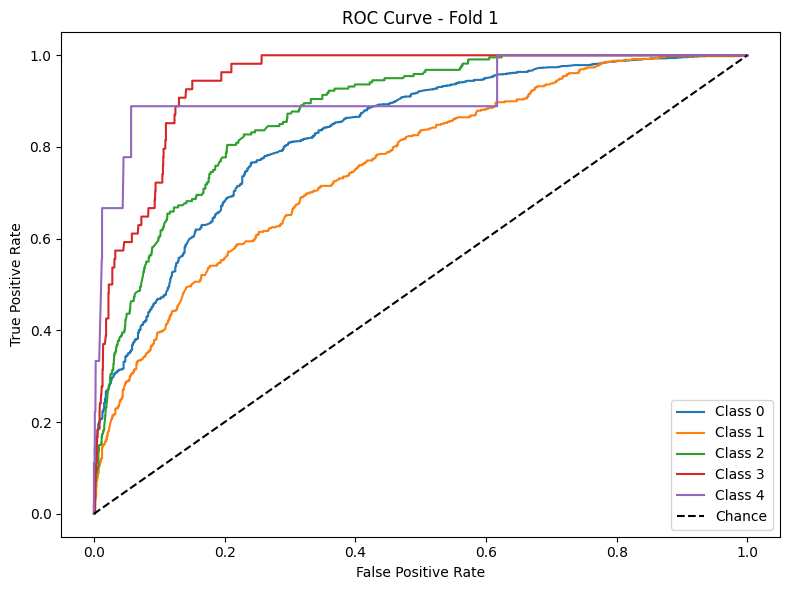

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3658
[LightGBM] [Info] Number of data points in the train set: 9037, number of used features: 52
[LightGBM] [Info] Start training from score -0.416760
[LightGBM] [Info] Start training from score -1.531449
[LightGBM] [Info] Start training from score -2.332576
[LightGBM] [Info] Start training from score -3.733804
[LightGBM] [Info] Start training from score -5.612575
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.91      0.84      1489
           1       0.55      0.32      0.40       489
           2       0.46      0.36

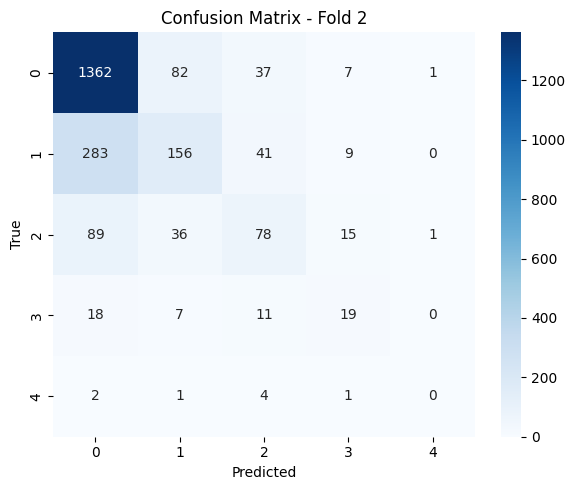

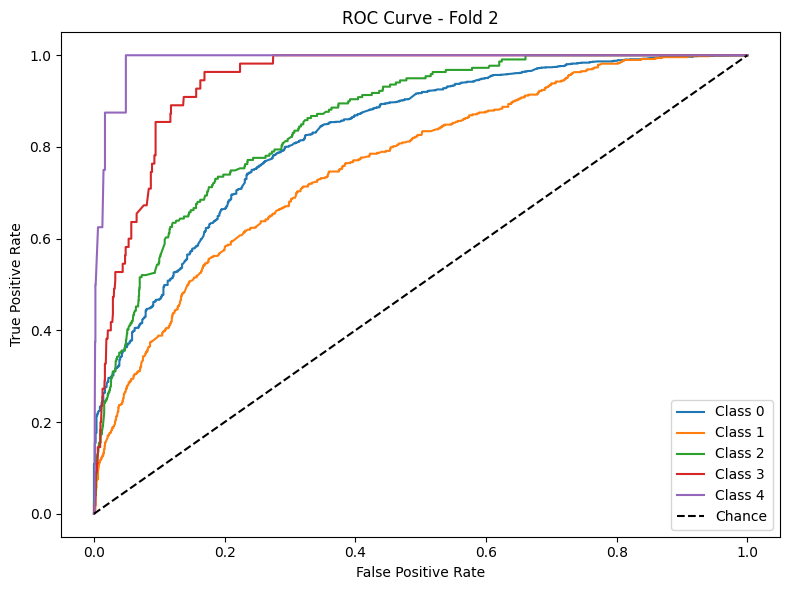

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 52
[LightGBM] [Info] Start training from score -0.416871
[LightGBM] [Info] Start training from score -1.531559
[LightGBM] [Info] Start training from score -2.332686
[LightGBM] [Info] Start training from score -3.729296
[LightGBM] [Info] Start training from score -5.612686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.90      0.83      1489
           1       0.51      0.32      0.39       489
           2       0.49      0.38

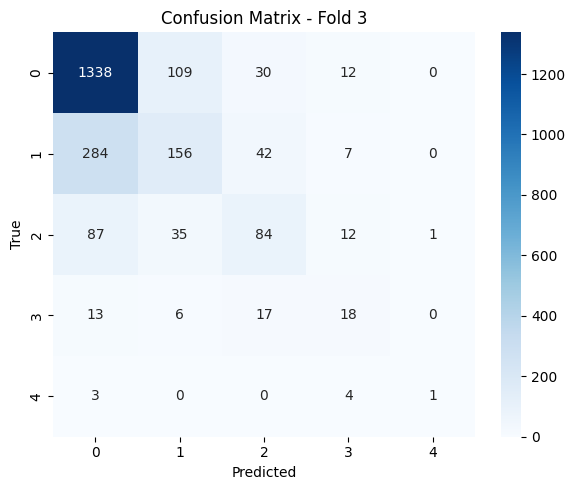

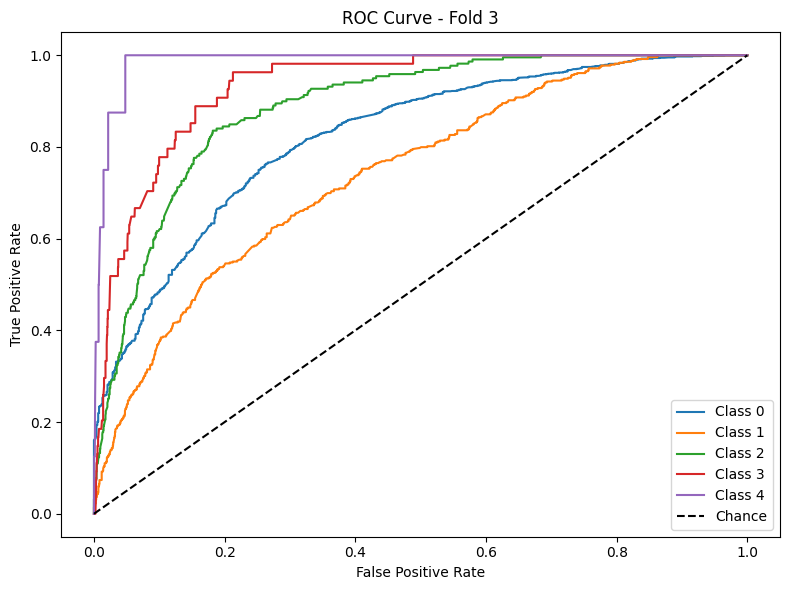

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3619
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 52
[LightGBM] [Info] Start training from score -0.416871
[LightGBM] [Info] Start training from score -1.531559
[LightGBM] [Info] Start training from score -2.332686
[LightGBM] [Info] Start training from score -3.729296
[LightGBM] [Info] Start training from score -5.612686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.91      0.83      1489
           1       0.59      0.33      0.42       489
           2       0.49      0.38

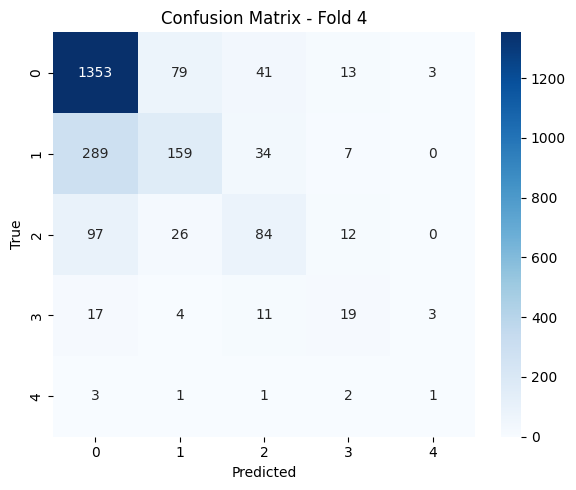

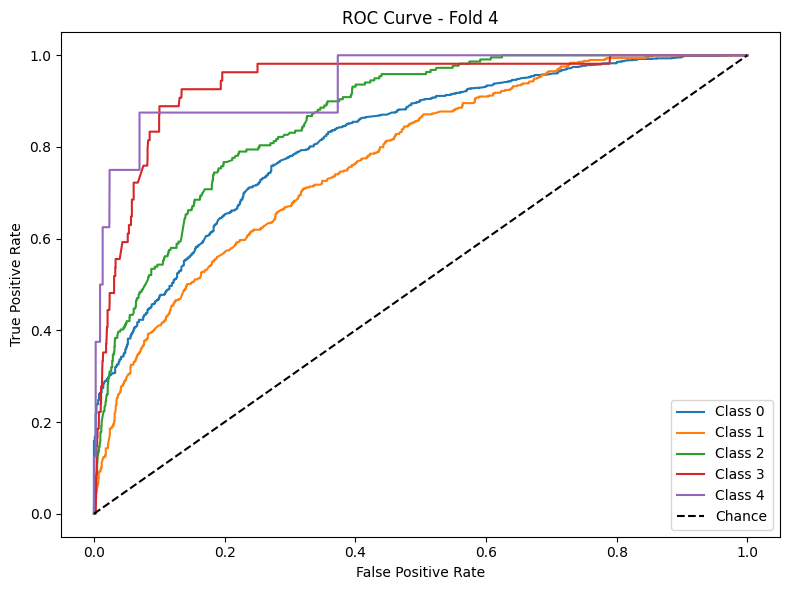

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3568
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 52
[LightGBM] [Info] Start training from score -0.417039
[LightGBM] [Info] Start training from score -1.531048
[LightGBM] [Info] Start training from score -2.332686
[LightGBM] [Info] Start training from score -3.729296
[LightGBM] [Info] Start training from score -5.612686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.91      0.85      1490
           1       0.57      0.37      0.45       488
           2       0.45      0.37

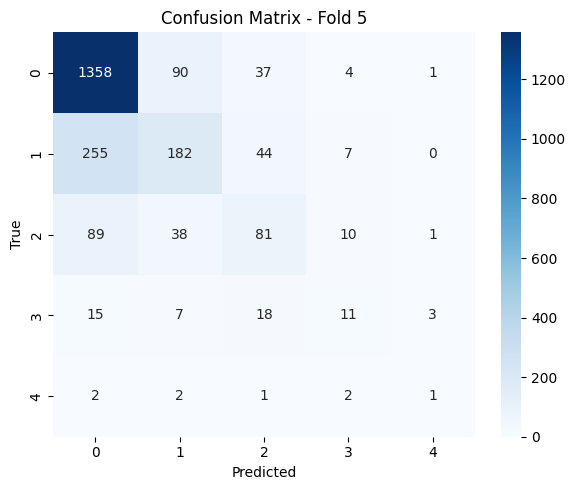

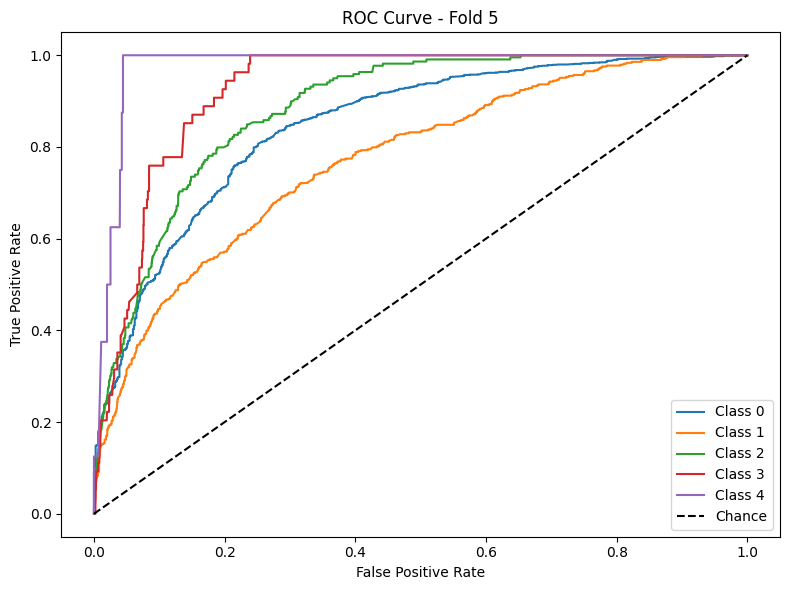


Average Accuracy: 0.7155
Average F1 Macro: 0.4270
Average AUC: 0.8722

Top Feature Importances:
remaining_time        46106
cluster               36164
total_words_phase1    21069
eigenvector           14507
degree                12916
school                10472
total_words_phase2    10155
closeness              8249
exercise_count         7587
user_month             6502
dtype: int32

=== Training Phase 3 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[LightGBM] [Info] Start training from score -3.733693
[LightGBM] [Info] Start training from score -5.612464
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

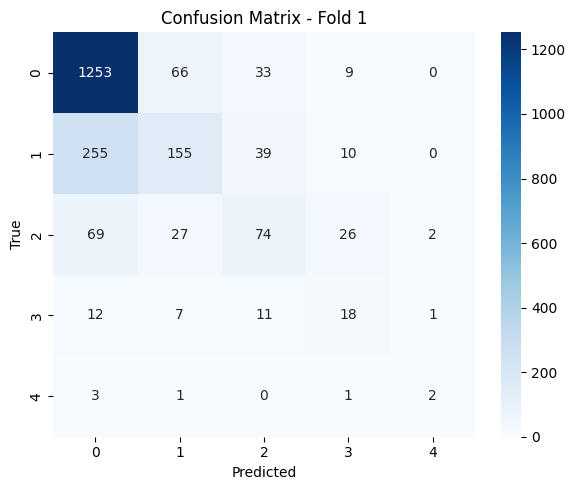

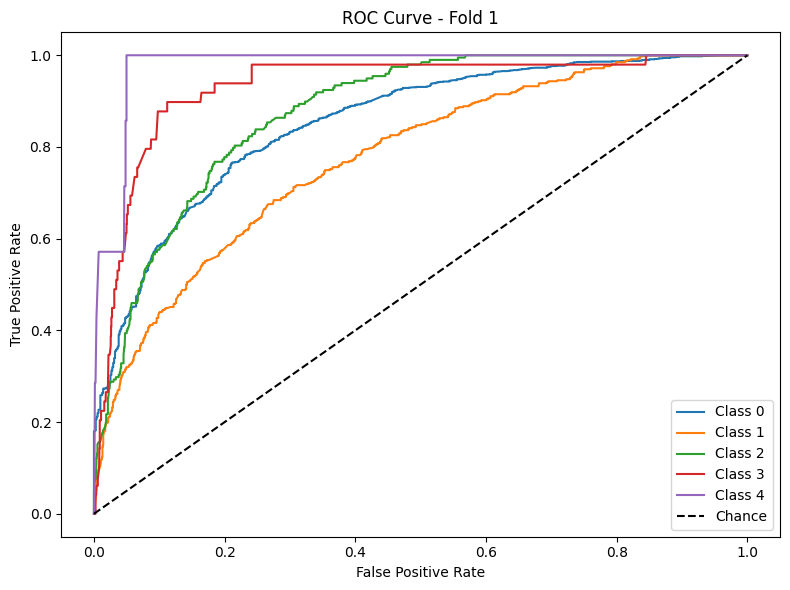

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3947
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 66
[LightGBM] [Info] Start training from score -0.421690
[LightGBM] [Info] Start training from score -1.507519
[LightGBM] [Info] Start training from score -2.350110
[LightGBM] [Info] Start training from score -3.735141
[LightGBM] [Info] Start training from score -5.691204
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.91      0.84      1360
           1       0.58      0.36      0.44       459
           2       0.48      0.38

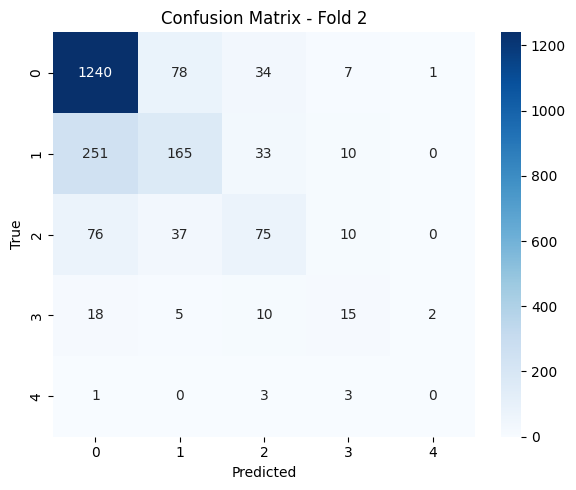

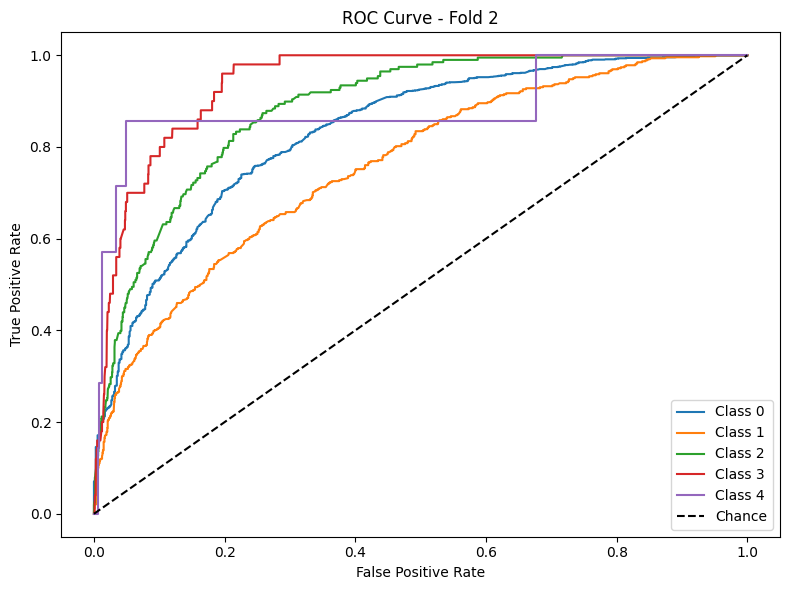

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3882
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 66
[LightGBM] [Info] Start training from score -0.421690
[LightGBM] [Info] Start training from score -1.507519
[LightGBM] [Info] Start training from score -2.350110
[LightGBM] [Info] Start training from score -3.735141
[LightGBM] [Info] Start training from score -5.691204
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.90      0.84      1360
           1       0.53      0.32      0.40       459
           2       0.43      0.42

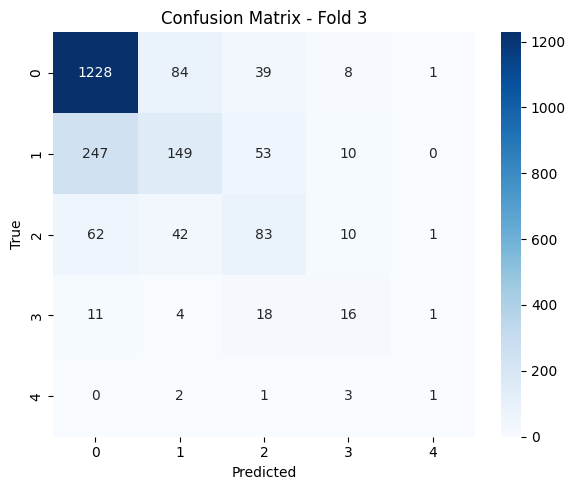

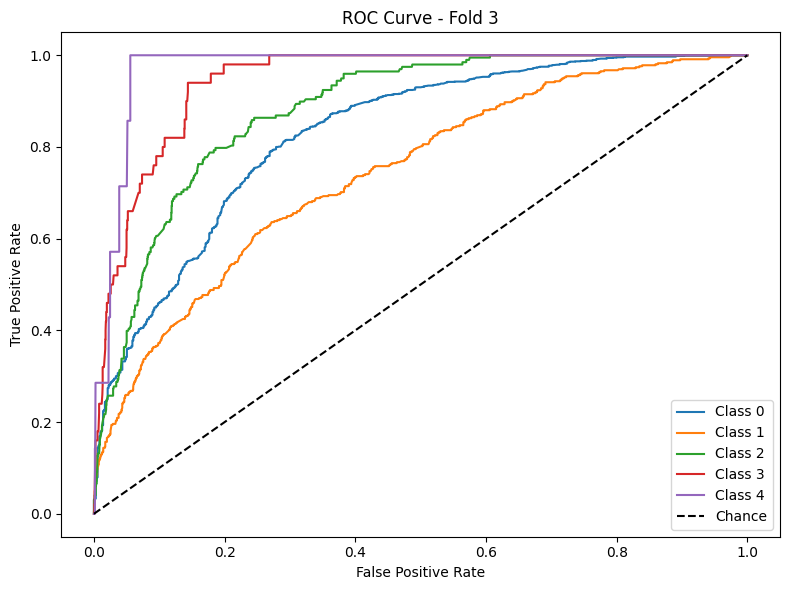

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3908
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 66
[LightGBM] [Info] Start training from score -0.421690
[LightGBM] [Info] Start training from score -1.507519
[LightGBM] [Info] Start training from score -2.350110
[LightGBM] [Info] Start training from score -3.735141
[LightGBM] [Info] Start training from score -5.691204
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.90      0.83      1360
           1       0.53      0.34      0.42       459
           2       0.51      0.37

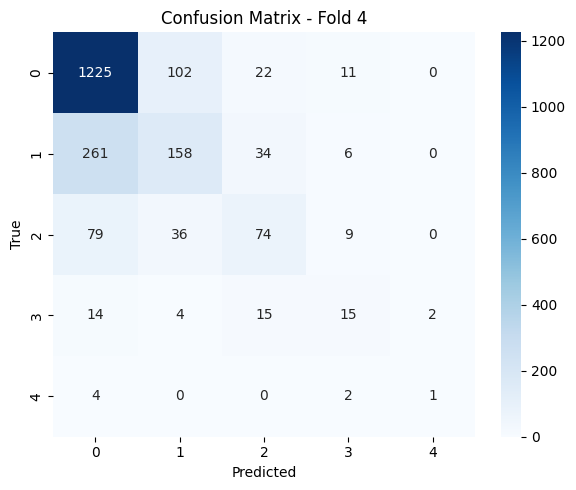

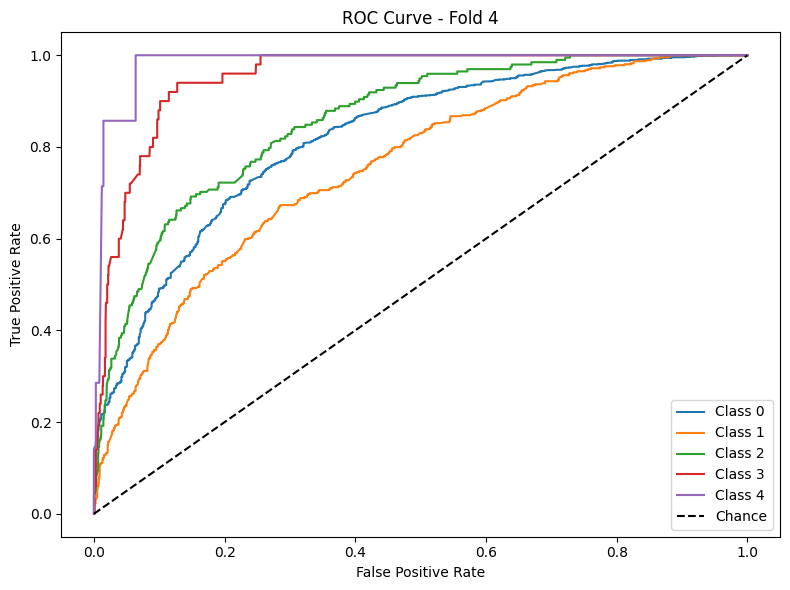

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3850
[LightGBM] [Info] Number of data points in the train set: 8296, number of used features: 65
[LightGBM] [Info] Start training from score -0.421811
[LightGBM] [Info] Start training from score -1.508184
[LightGBM] [Info] Start training from score -2.348967
[LightGBM] [Info] Start training from score -3.730224
[LightGBM] [Info] Start training from score -5.691324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.89      0.83      1360
           1       0.52      0.35      0.42       460
           2       0.45      0.39

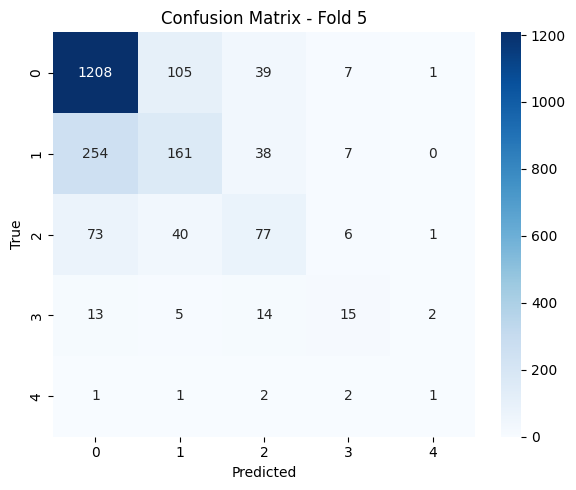

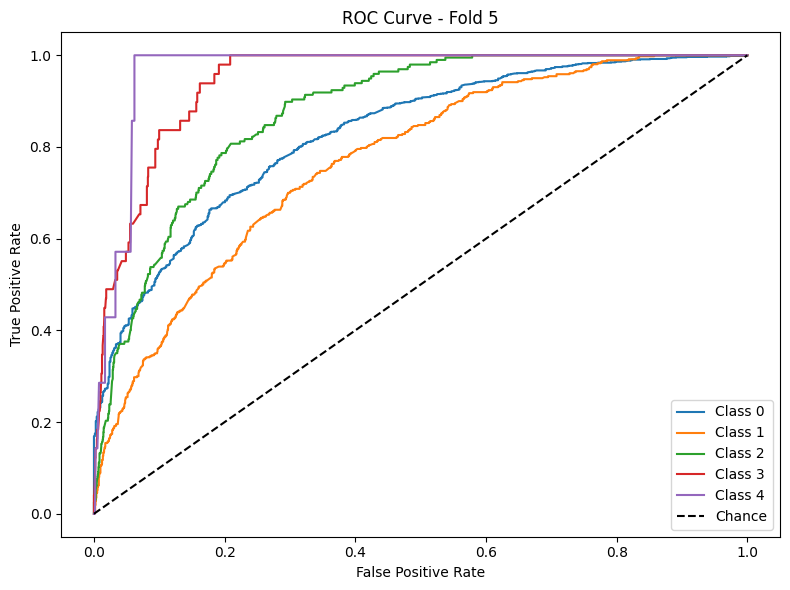


Average Accuracy: 0.7145
Average F1 Macro: 0.4378
Average AUC: 0.8737

Top Feature Importances:
remaining_time        42543
cluster               35096
total_words_phase1    17563
degree                12131
eigenvector           11535
school                10355
total_words_phase3    10324
total_words_phase2     9070
closeness              8083
exercise_count         6757
dtype: int32

=== Training Phase 4 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

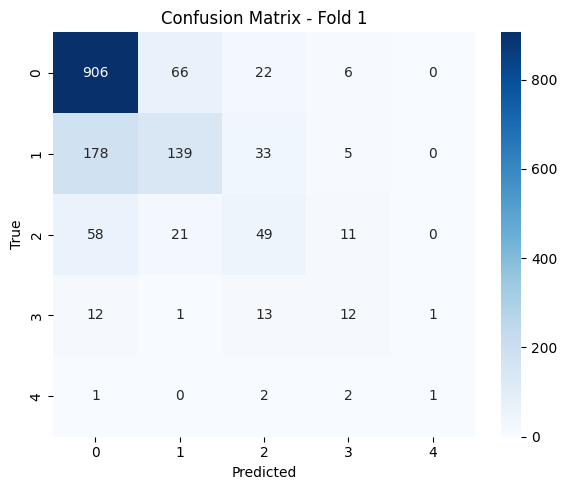

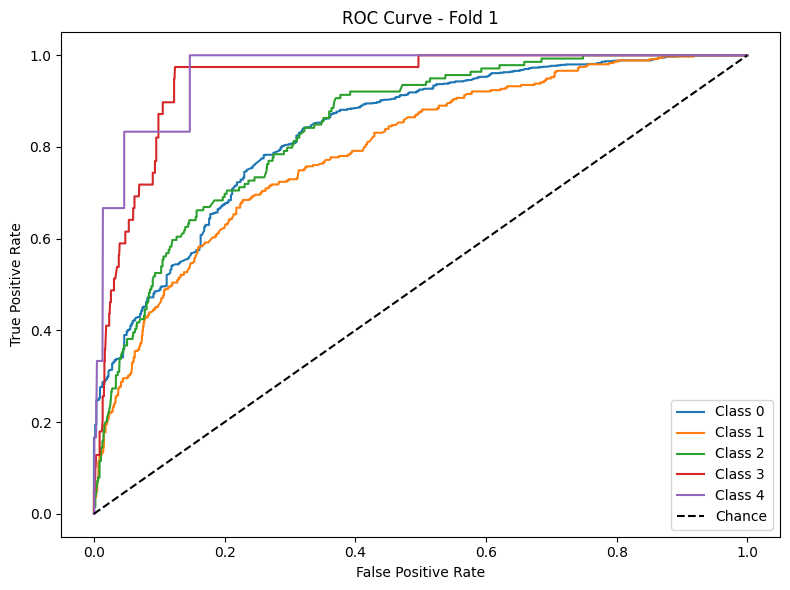

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4830
[LightGBM] [Info] Number of data points in the train set: 6154, number of used features: 81
[LightGBM] [Info] Start training from score -0.431558
[LightGBM] [Info] Start training from score -1.465038
[LightGBM] [Info] Start training from score -2.407693
[LightGBM] [Info] Start training from score -3.668612
[LightGBM] [Info] Start training from score -5.546804
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.90      0.84      1000
           1       0.58      0.43      0.49       355
           2       0.58      0.44      0.50       139
           3       0.43      0.30      0.35        40


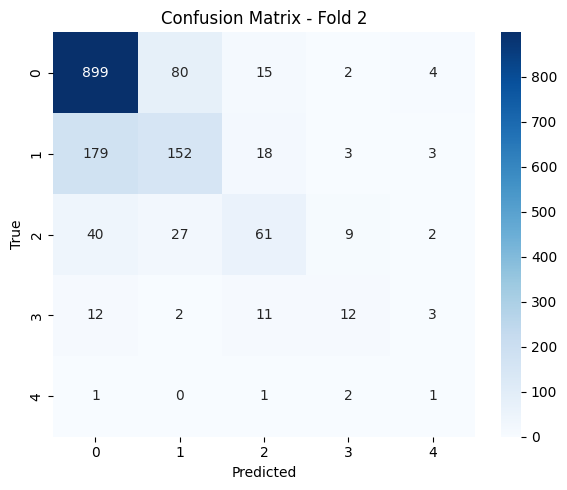

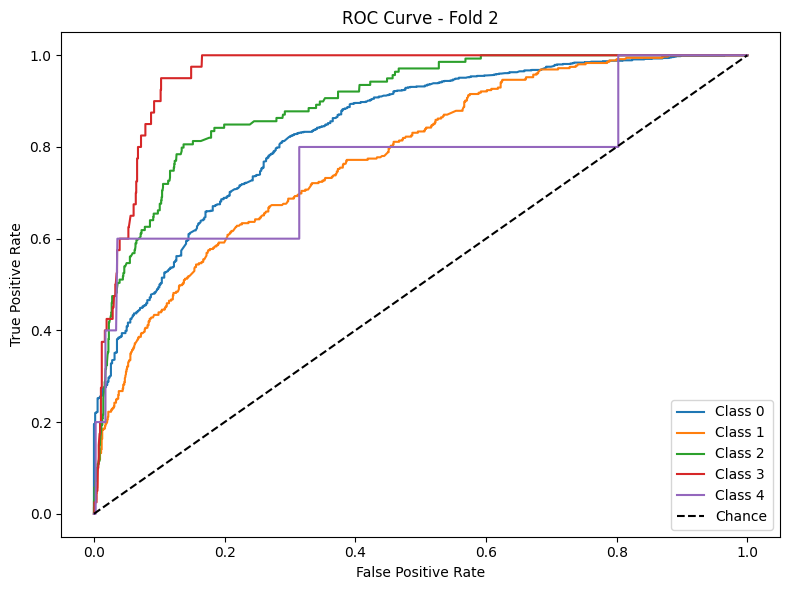

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4849
[LightGBM] [Info] Number of data points in the train set: 6154, number of used features: 81
[LightGBM] [Info] Start training from score -0.431308
[LightGBM] [Info] Start training from score -1.465038
[LightGBM] [Info] Start training from score -2.407693
[LightGBM] [Info] Start training from score -3.668612
[LightGBM] [Info] Start training from score -5.589363
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.92      0.85       999
           1       0.63      0.41      0.50       355
           2       0.53      0.40      0.46       139
           3       0.40      0.35      0.37        40


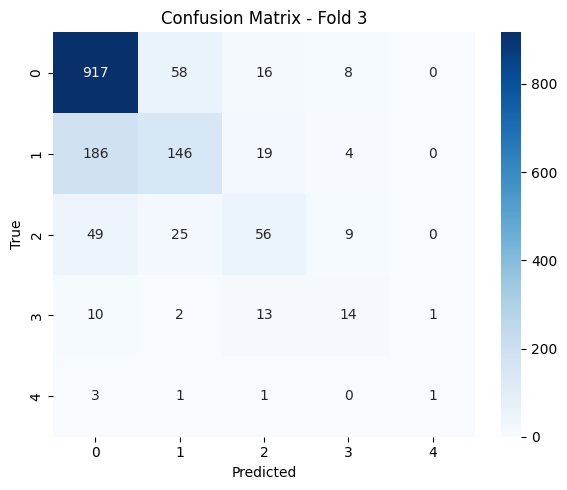

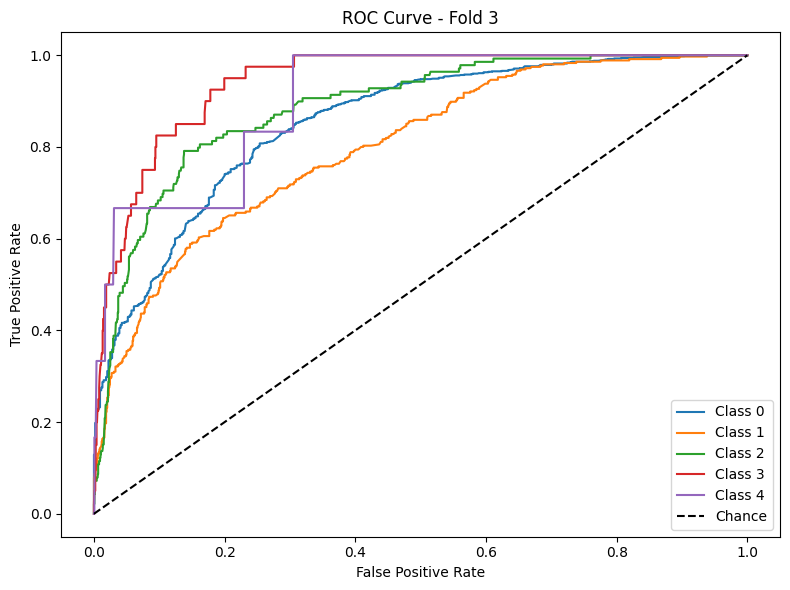

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4811
[LightGBM] [Info] Number of data points in the train set: 6155, number of used features: 82
[LightGBM] [Info] Start training from score -0.431471
[LightGBM] [Info] Start training from score -1.465904
[LightGBM] [Info] Start training from score -2.406052
[LightGBM] [Info] Start training from score -3.662425
[LightGBM] [Info] Start training from score -5.589526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.93      0.85       999
           1       0.64      0.38      0.48       356
           2       0.57      0.42      0.49       138
           3       0.38      0.44      0.40        39


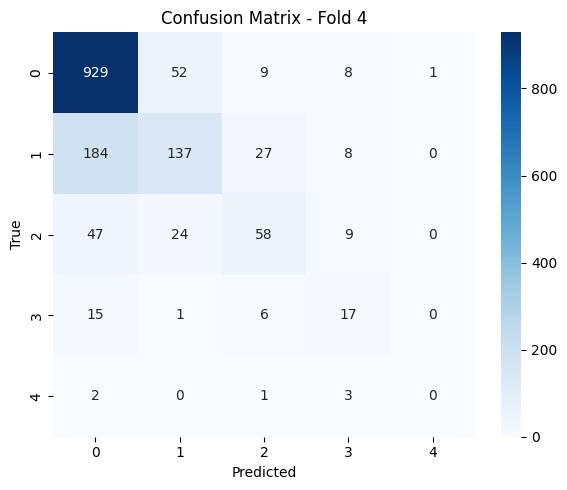

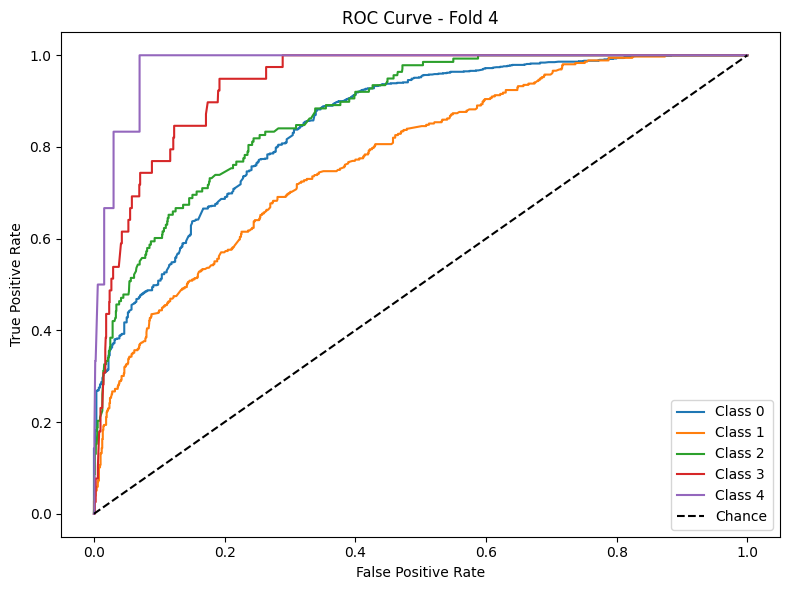

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4877
[LightGBM] [Info] Number of data points in the train set: 6155, number of used features: 81
[LightGBM] [Info] Start training from score -0.431471
[LightGBM] [Info] Start training from score -1.465904
[LightGBM] [Info] Start training from score -2.406052
[LightGBM] [Info] Start training from score -3.662425
[LightGBM] [Info] Start training from score -5.589526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.91      0.85       999
           1       0.59      0.39      0.47       356
           2       0.44      0.38      0.41       138
           3       0.40      0.41      0.41        39


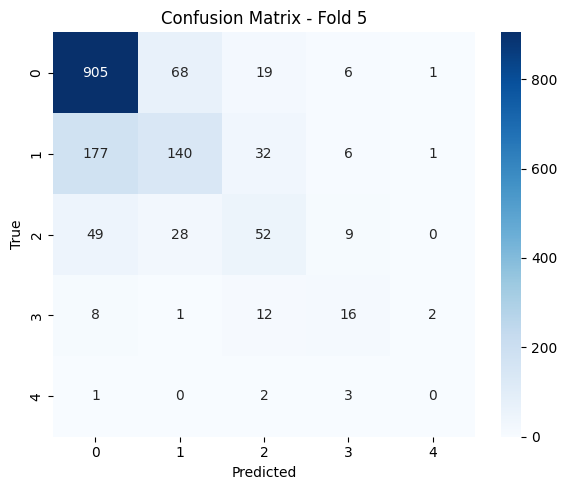

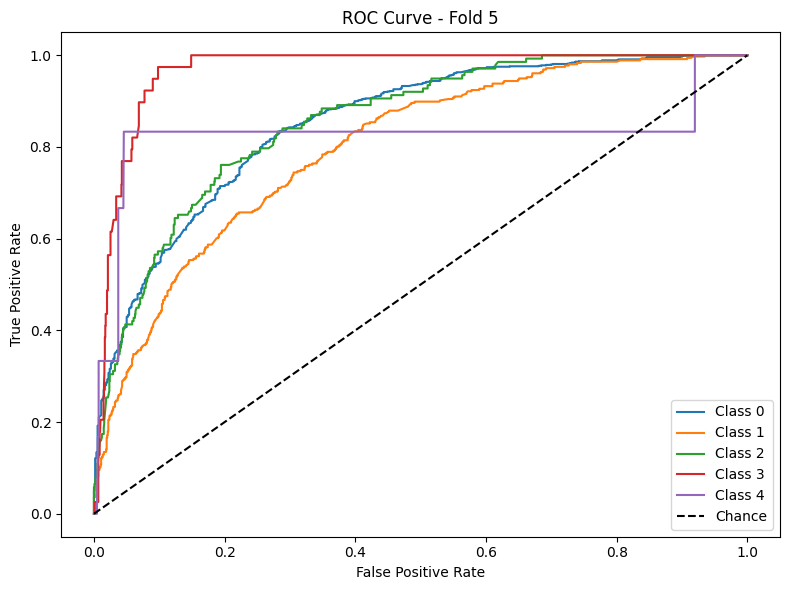


Average Accuracy: 0.7305
Average F1 Macro: 0.4540
Average AUC: 0.8688

Top Feature Importances:
remaining_time        2031
cluster               1482
total_words_phase1     935
eigenvector            812
total_words_phase4     757
degree                 702
school                 499
closeness              402
total_words_phase2     386
total_positive1        338
dtype: int32


In [5]:
phase_paths = [f"/kaggle/input/smotesvm-train-enrich-data/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n=== Training Phase {i} ===")
    sample = False
    model, scaler, best_fold, metrics = train_phase(phase_path, param_dist, sample = sample)
    # Save best model & scaler
    if sample: 
        temp = "sample"
    else: temp = "no_sample"
    joblib.dump(model, f"best_model_{temp}_phase{i}.pkl")
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
    results[f"phase{i}"] = metrics


## Predict on Test Data

In [6]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

def predict_on_test(test_file_path, model_file, scaler_file, school_mapping_file):
    # Load model, scaler, and mapping
    model = joblib.load(model_file)
    scaler = joblib.load(scaler_file)
    mapping = joblib.load(school_mapping_file)

    # Load and preprocess test data
    df_test = pd.read_csv(test_file_path)
    y_test = df_test['label_encoded']
    X_test = df_test.drop(columns=['user_id', 'course_id', 'label_encoded', 'label', 'total_score'], axis=1)

    # Apply school mapping
    if 'school' in X_test.columns:
        X_test['school'] = X_test['school'].map(mapping).fillna(0).astype(int)

    # Scale features
    X_test_scaled = scaler.transform(X_test)

    # Predict
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)

    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # AUC Score
    classes = model.classes_
    y_test_bin = label_binarize(y_test, classes=classes)
    auc_score = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
    print(f"\nTest AUC (macro-average, OVR): {auc_score:.4f}")

    # Plot ROC Curves
    plt.figure(figsize=(8, 6))
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        plt.plot(fpr, tpr, label=f'Class {cls}')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title('ROC Curves for Test Set')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return y_pred


Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.95      0.92       568
           1       0.39      0.38      0.39        63
           2       0.33      0.23      0.27        43
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         9

    accuracy                           0.82       698
   macro avg       0.32      0.31      0.32       698
weighted avg       0.78      0.82      0.80       698



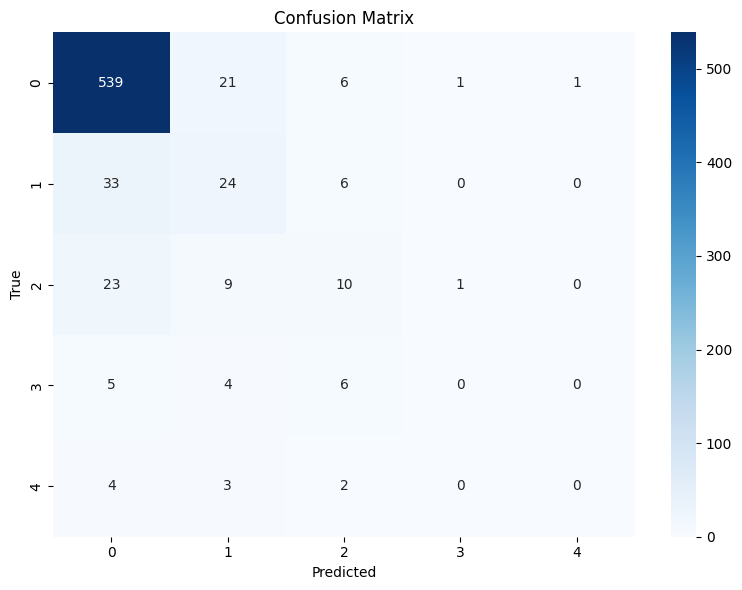


Test AUC (macro-average, OVR): 0.8464


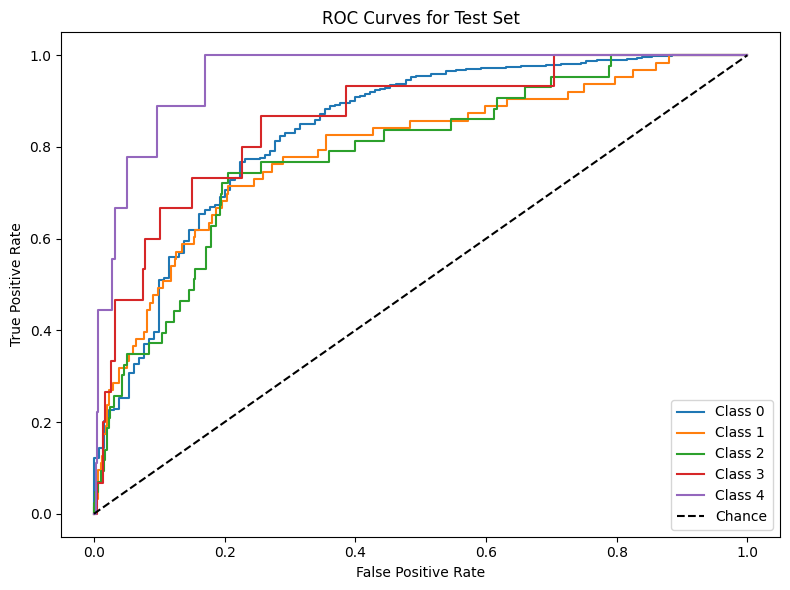


Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.97      0.92       544
           1       0.43      0.25      0.32        59
           2       0.26      0.19      0.22        42
           3       0.00      0.00      0.00        14
           4       1.00      0.11      0.20         9

    accuracy                           0.82       668
   macro avg       0.51      0.30      0.33       668
weighted avg       0.78      0.82      0.79       668



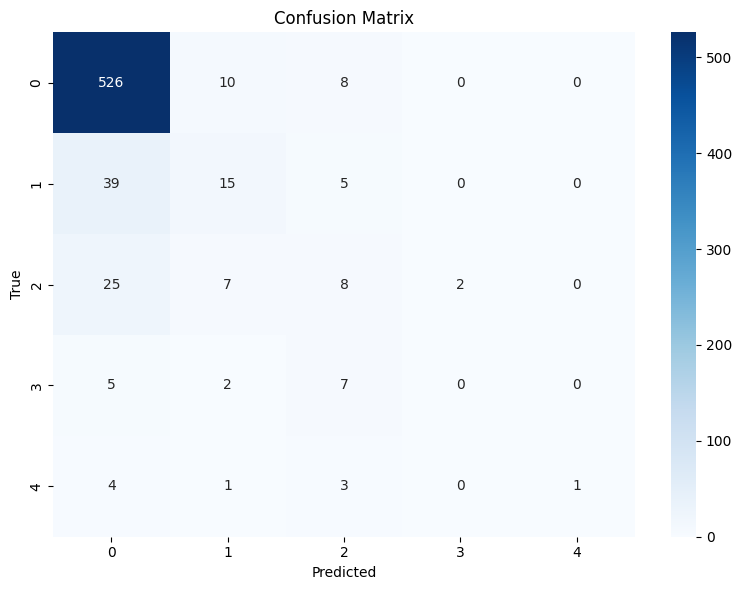


Test AUC (macro-average, OVR): 0.8629


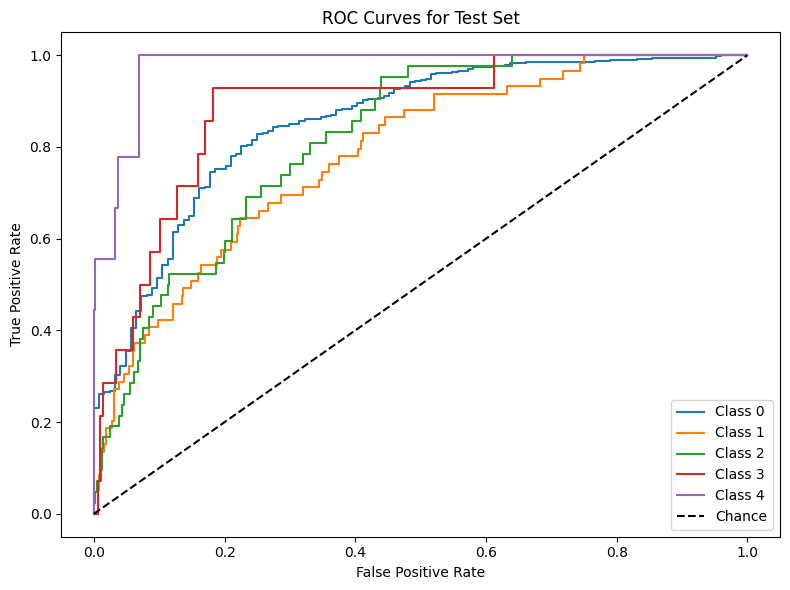


Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.98      0.92       455
           1       0.45      0.10      0.16        52
           2       0.24      0.17      0.20        29
           3       0.00      0.00      0.00        10
           4       0.75      0.38      0.50         8

    accuracy                           0.83       554
   macro avg       0.46      0.32      0.35       554
weighted avg       0.77      0.83      0.78       554



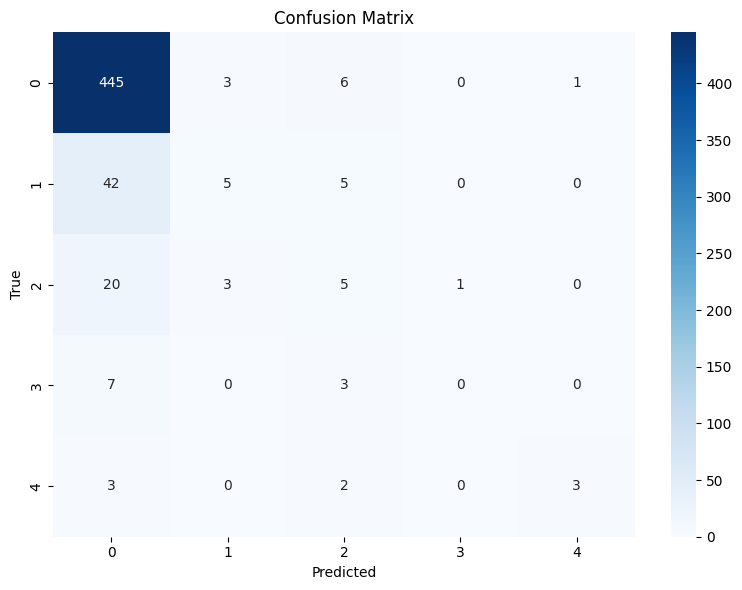


Test AUC (macro-average, OVR): 0.8356


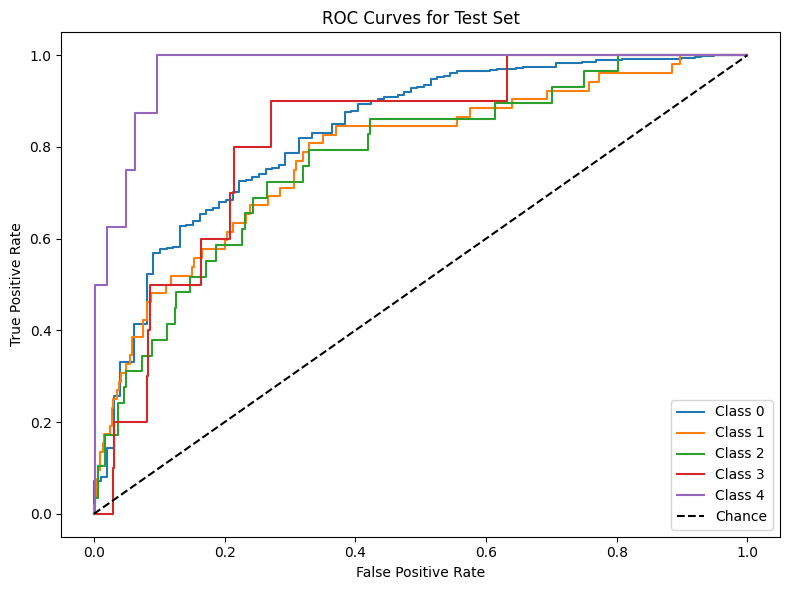


Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.94      0.91       395
           1       0.18      0.12      0.15        40
           2       0.27      0.29      0.28        24
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.81       477
   macro avg       0.27      0.27      0.27       477
weighted avg       0.76      0.81      0.78       477



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


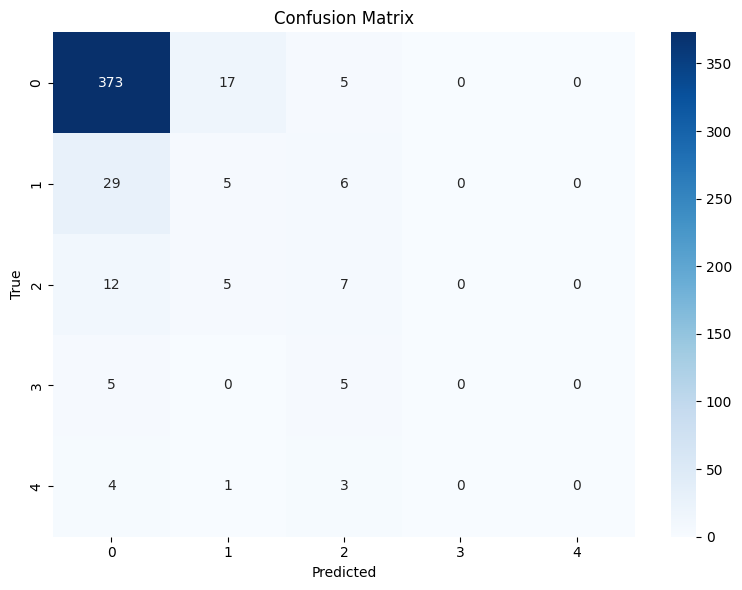


Test AUC (macro-average, OVR): 0.8033


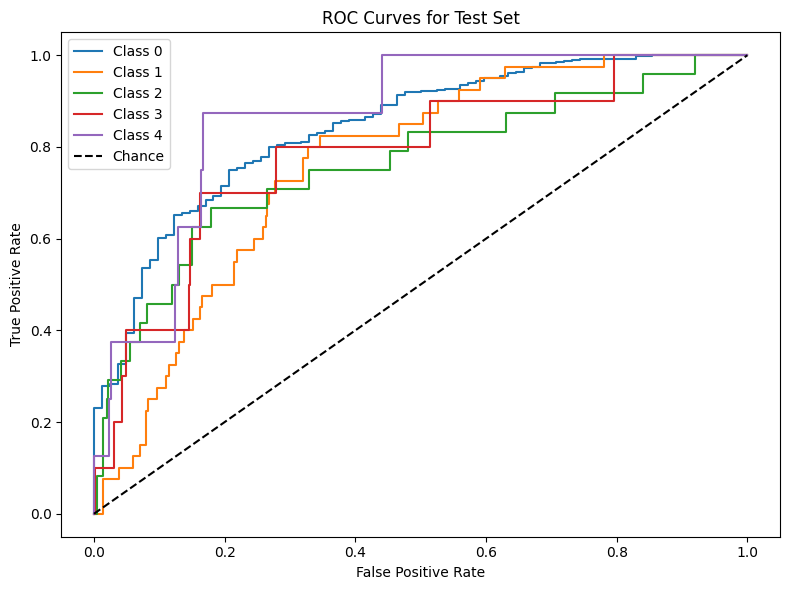

In [7]:
import glob

for i in range(1, 5):
    test_dir = f'/kaggle/input/enrich-data-node-clustering/phase{i}/user_train_phase_{i}_test.csv'
    
    # Get model and scaler using glob
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.pkl'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    # School mapping path
    school_mapping_file = f'/kaggle/input/smotesvm-train-enrich-data/outputs/phase{i}/mappings/school_mapping.pkl'

    # Predict on test set
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)


# Sample


=== Training Phase 1 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[LightGBM] [Info] Total Bins 4126
[LightGBM] [Info] Number of data points in the train set: 4103, number of used features: 78
[LightGBM] [Info] Start training from score -0.431514
[LightGBM] [Info] Start training from score -1.465119
[LightGBM] [Info] Start training from score -2.408677
[LightGBM] [Info] Start training from score -3.656035
[LightGBM] [Info] Start training from score -5.611423
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

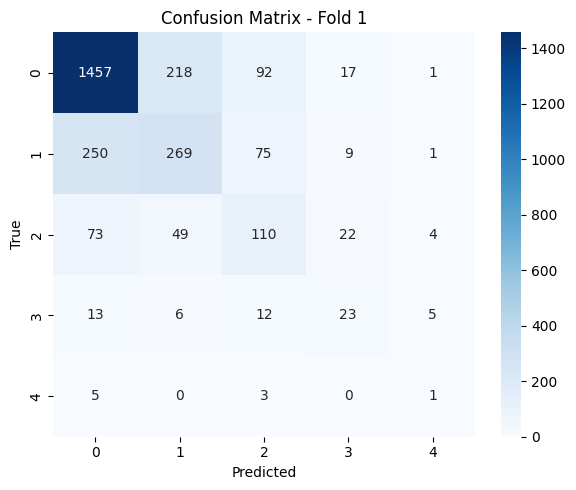

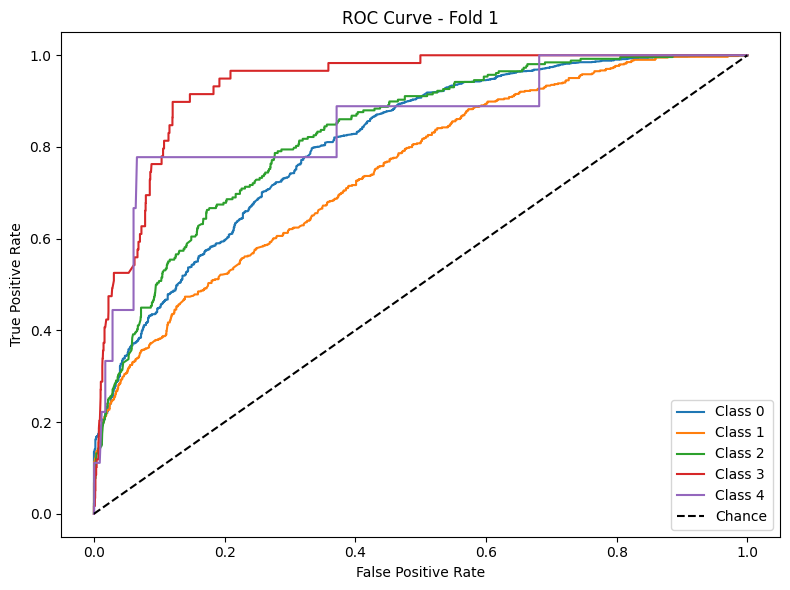

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8602
[LightGBM] [Info] Number of data points in the train set: 31580, number of used features: 36
[LightGBM] [Info] Start training from score -1.486671
[LightGBM] [Info] Start training from score -1.486671
[LightGBM] [Info] Start training from score -1.486671
[LightGBM] [Info] Start training from score -1.486671
[LightGBM] [Info] Start training from score -2.348593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

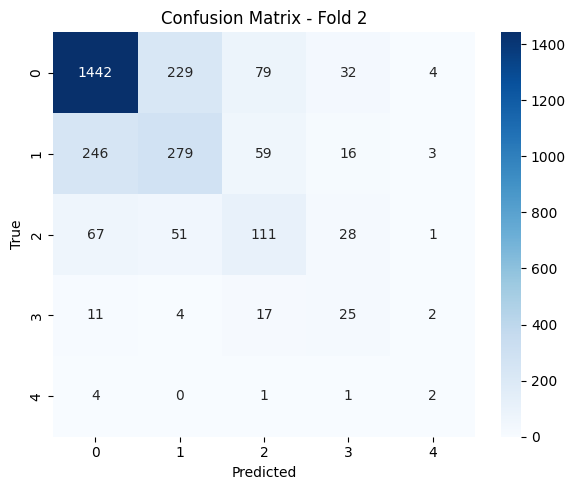

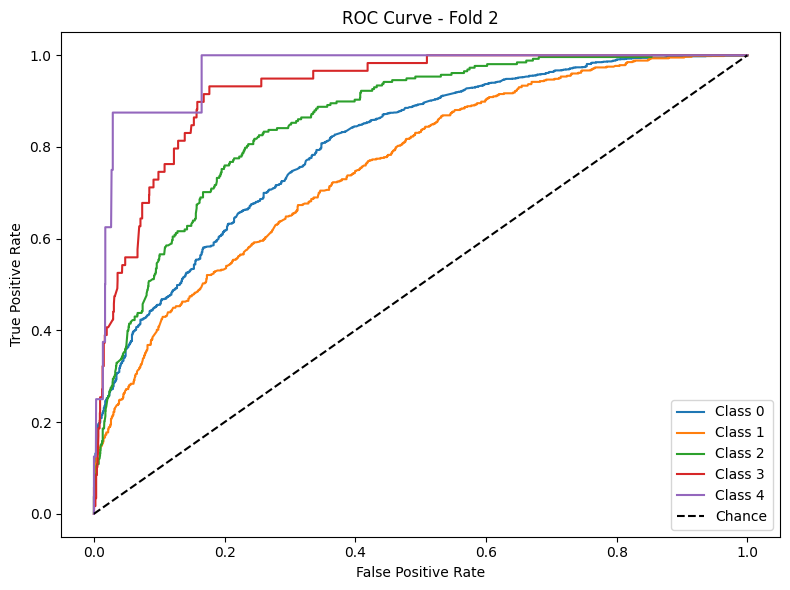

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004763 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8491
[LightGBM] [Info] Number of data points in the train set: 31580, number of used features: 36
[LightGBM] [Info] Start training from score -1.486671
[LightGBM] [Info] Start training from score -1.486671
[LightGBM] [Info] Start training from score -1.486671
[LightGBM] [Info] Start training from score -1.486671
[LightGBM] [Info] Start training from score -2.348593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

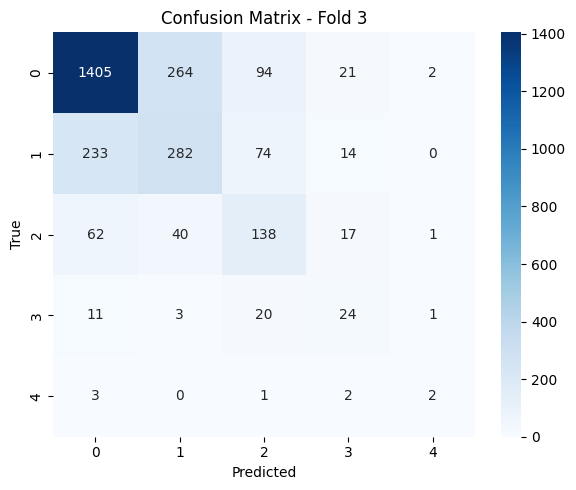

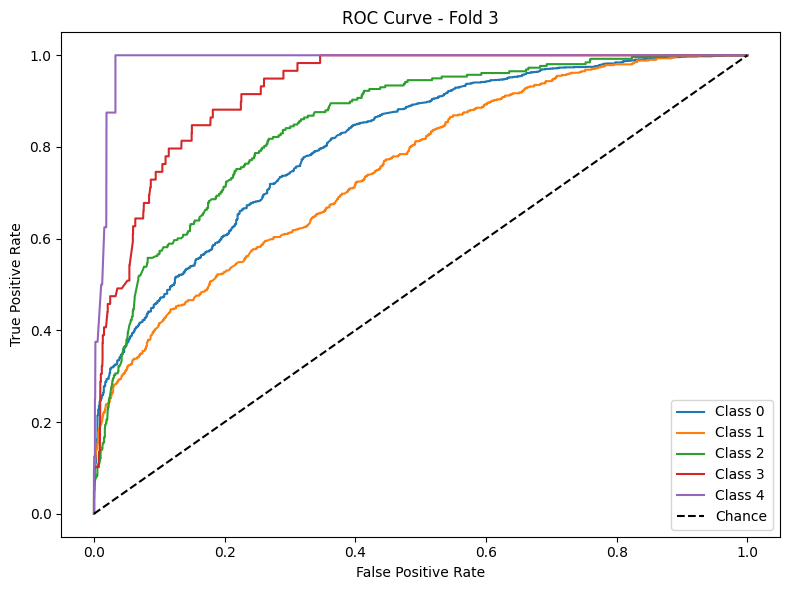

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8532
[LightGBM] [Info] Number of data points in the train set: 31584, number of used features: 36
[LightGBM] [Info] Start training from score -1.486658
[LightGBM] [Info] Start training from score -1.486658
[LightGBM] [Info] Start training from score -1.486658
[LightGBM] [Info] Start training from score -1.486658
[LightGBM] [Info] Start training from score -2.348719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

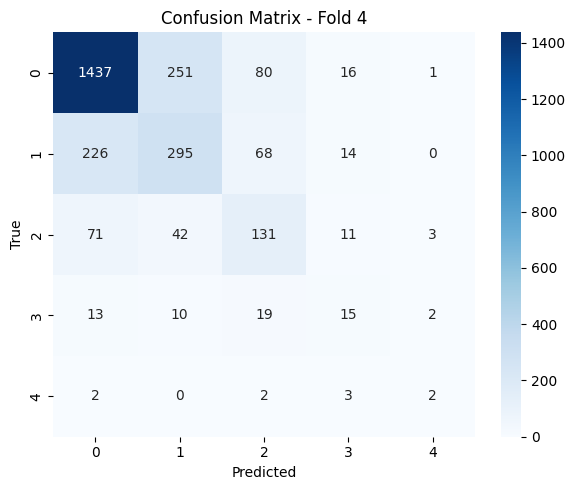

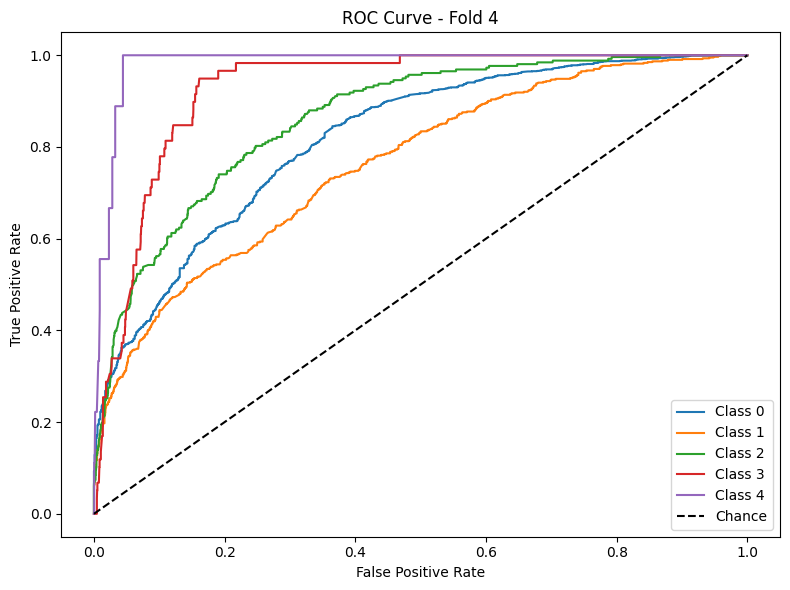

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8593
[LightGBM] [Info] Number of data points in the train set: 31584, number of used features: 36
[LightGBM] [Info] Start training from score -1.486658
[LightGBM] [Info] Start training from score -1.486658
[LightGBM] [Info] Start training from score -1.486658
[LightGBM] [Info] Start training from score -1.486658
[LightGBM] [Info] Start training from score -2.348719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

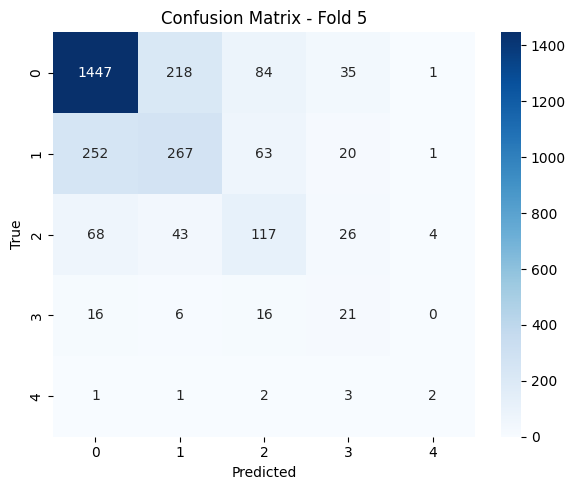

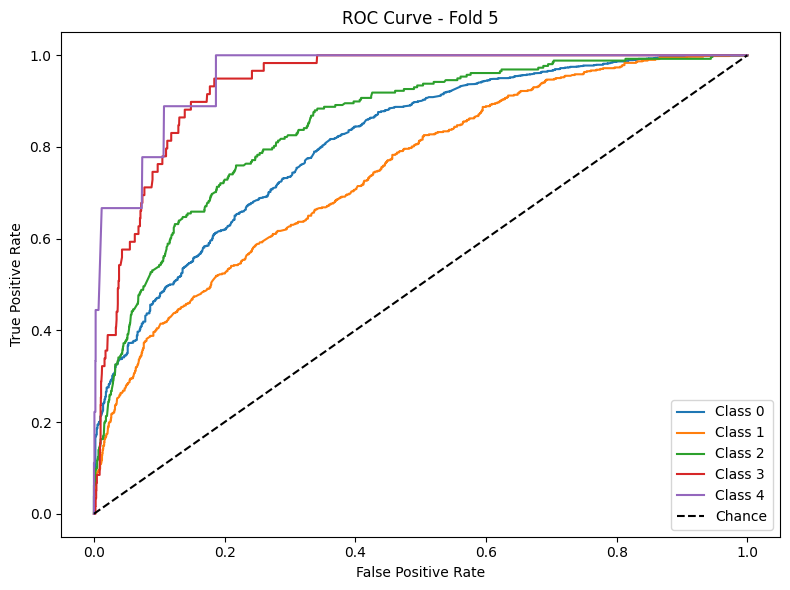


Average Accuracy: 0.6856
Average F1 Macro: 0.4483
Average AUC: 0.8585

Top Feature Importances:
remaining_time                 64623
cluster                        46227
total_words_phase1             18509
school                         13789
user_month                     12317
degree                         11811
eigenvector                     9450
total_neutral1                  6677
user_time_since_last_course     5647
closeness                       5475
dtype: int32

=== Training Phase 2 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

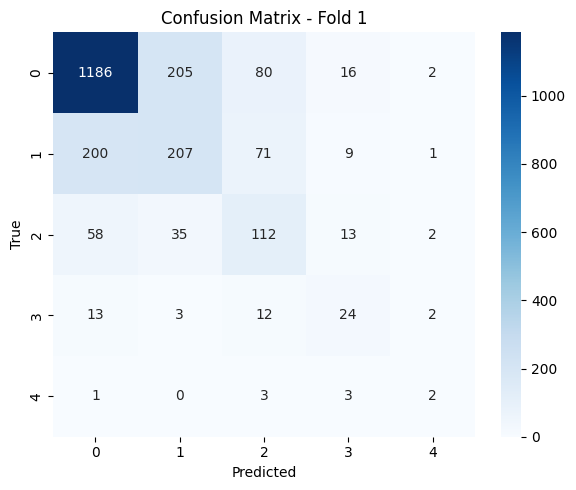

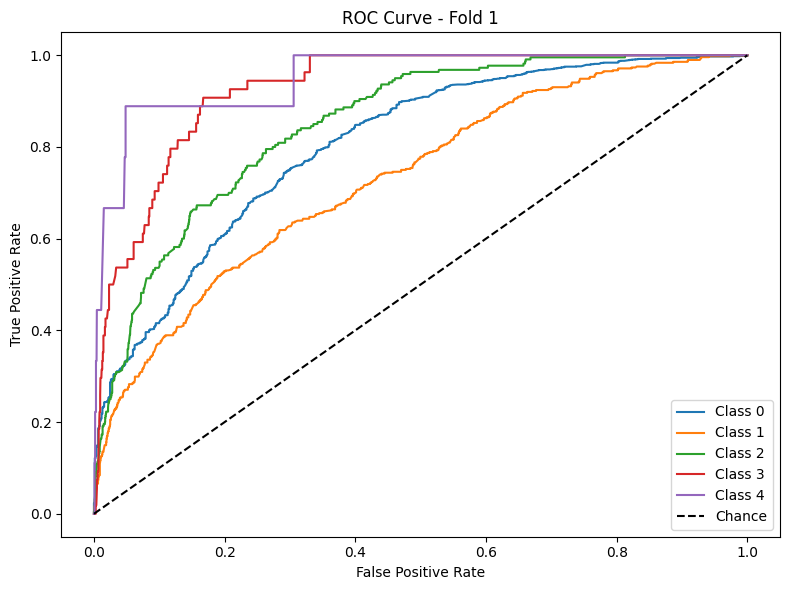

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11690
[LightGBM] [Info] Number of data points in the train set: 26346, number of used features: 52
[LightGBM] [Info] Start training from score -1.486749
[LightGBM] [Info] Start training from score -1.486749
[LightGBM] [Info] Start training from score -1.486749
[LightGBM] [Info] Start training from score -1.486749
[LightGBM] [Info] Start training from score -2.347852
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

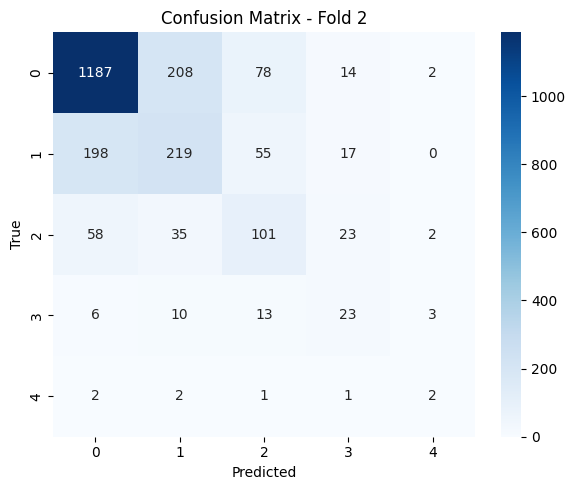

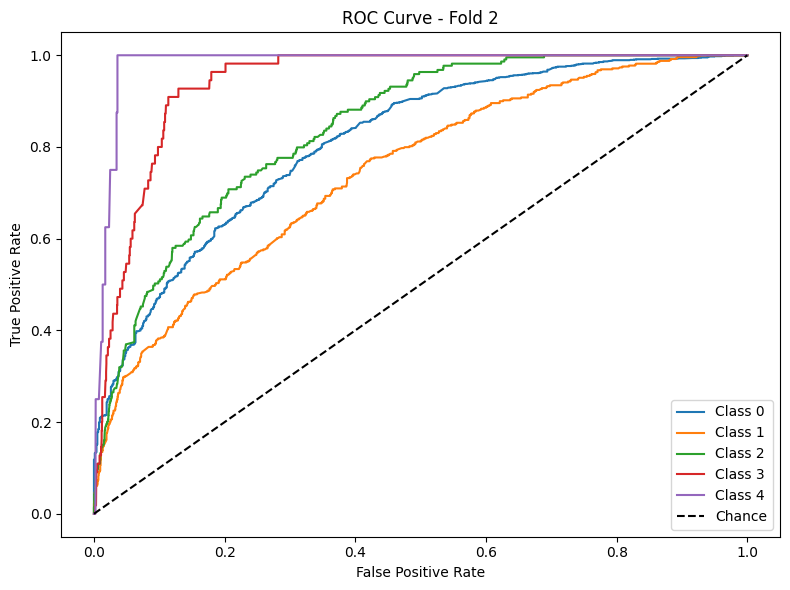

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11815
[LightGBM] [Info] Number of data points in the train set: 26346, number of used features: 52
[LightGBM] [Info] Start training from score -1.486749
[LightGBM] [Info] Start training from score -1.486749
[LightGBM] [Info] Start training from score -1.486749
[LightGBM] [Info] Start training from score -1.486749
[LightGBM] [Info] Start training from score -2.347852
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

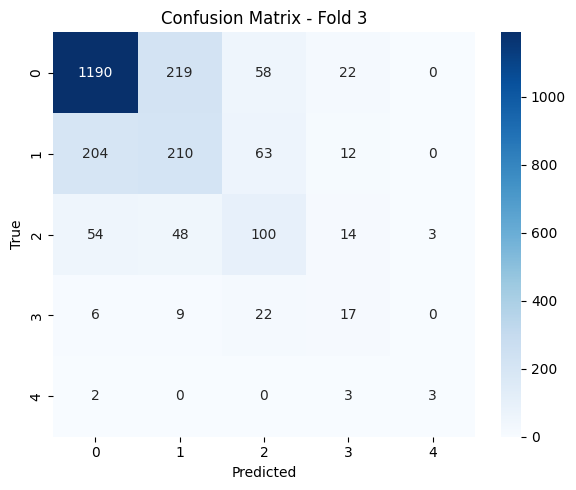

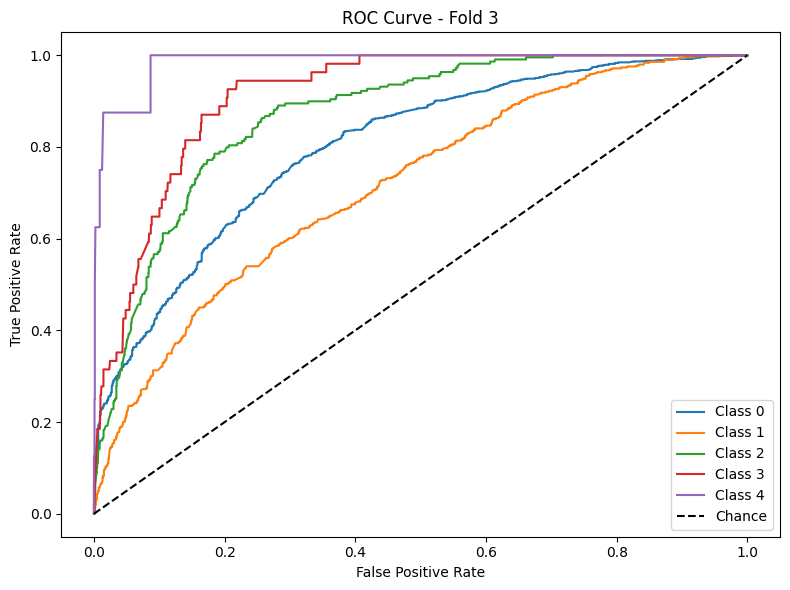

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11685
[LightGBM] [Info] Number of data points in the train set: 26346, number of used features: 52
[LightGBM] [Info] Start training from score -1.486749
[LightGBM] [Info] Start training from score -1.486749
[LightGBM] [Info] Start training from score -1.486749
[LightGBM] [Info] Start training from score -1.486749
[LightGBM] [Info] Start training from score -2.347852
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

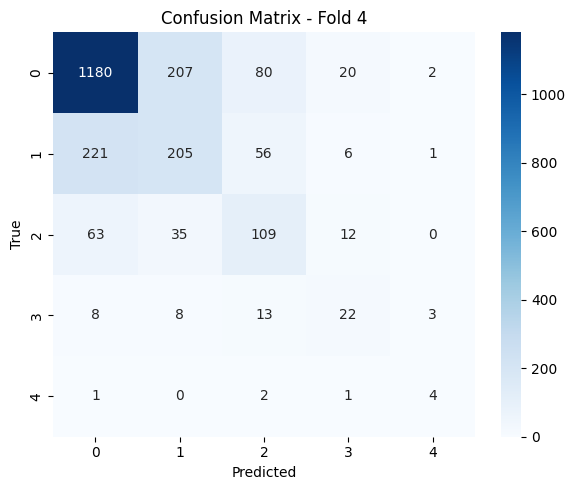

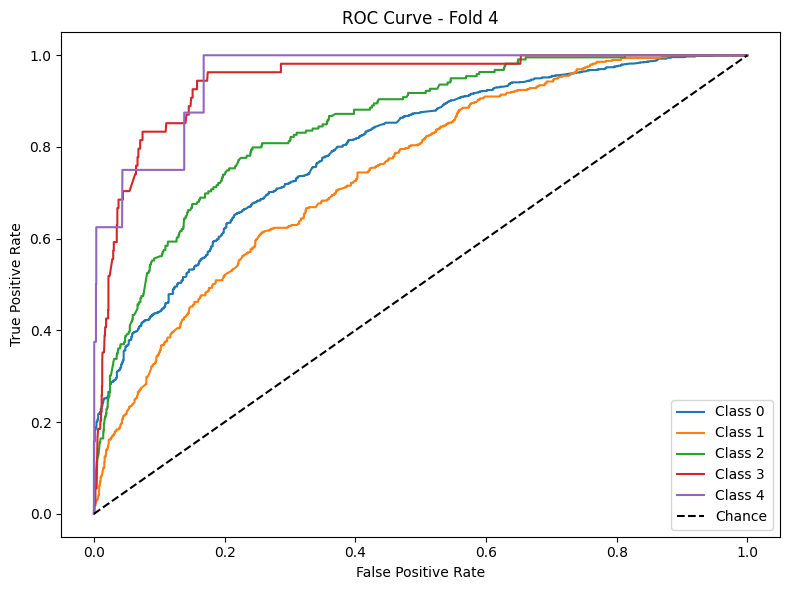

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11825
[LightGBM] [Info] Number of data points in the train set: 26342, number of used features: 52
[LightGBM] [Info] Start training from score -1.486766
[LightGBM] [Info] Start training from score -1.486766
[LightGBM] [Info] Start training from score -1.486766
[LightGBM] [Info] Start training from score -1.486766
[LightGBM] [Info] Start training from score -2.347700
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

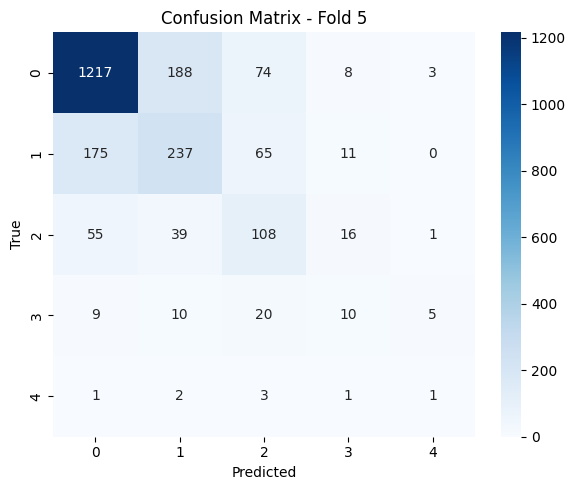

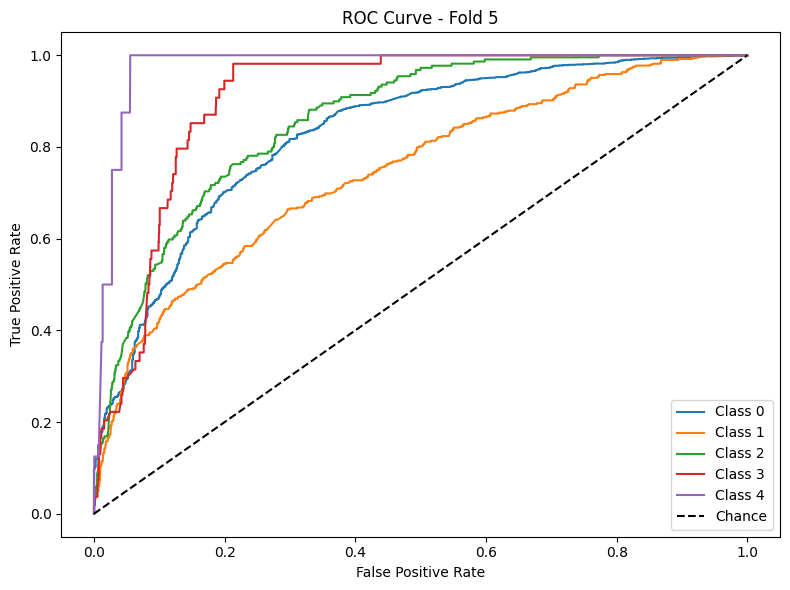


Average Accuracy: 0.6795
Average F1 Macro: 0.4624
Average AUC: 0.8590

Top Feature Importances:
remaining_time        27976
cluster               16822
total_words_phase1     6074
school                 5502
degree                 4821
eigenvector            4668
user_month             4249
closeness              2689
total_words_phase2     2551
total_neutral1         2204
dtype: int32

=== Training Phase 3 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

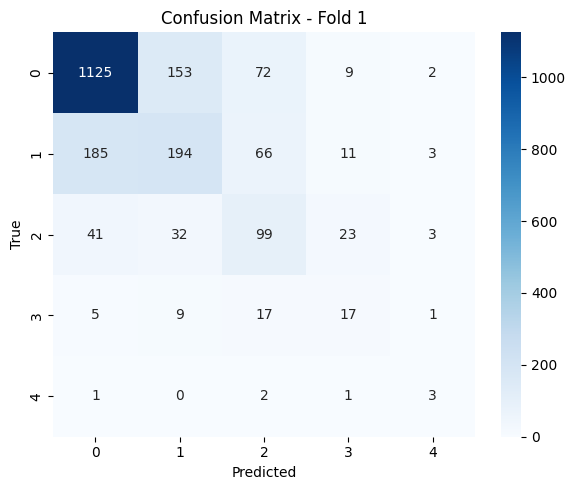

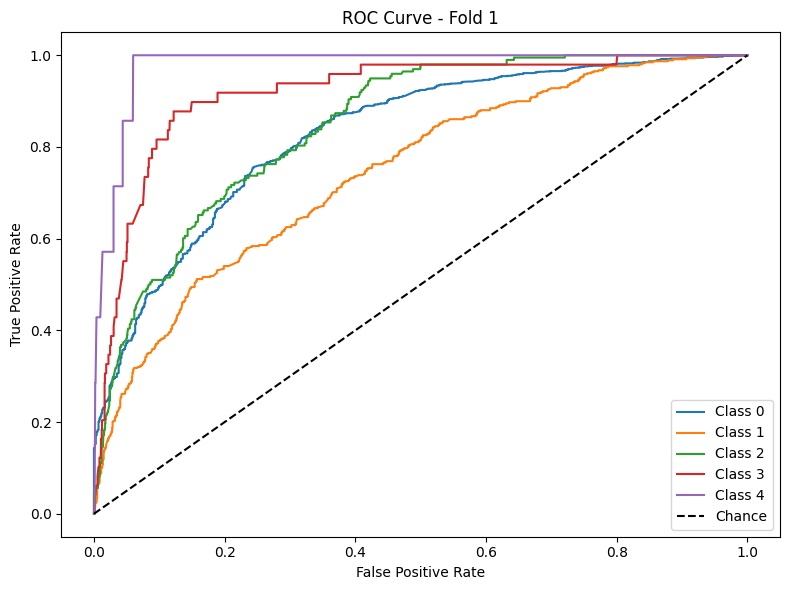

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14335
[LightGBM] [Info] Number of data points in the train set: 24063, number of used features: 67
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -2.348201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

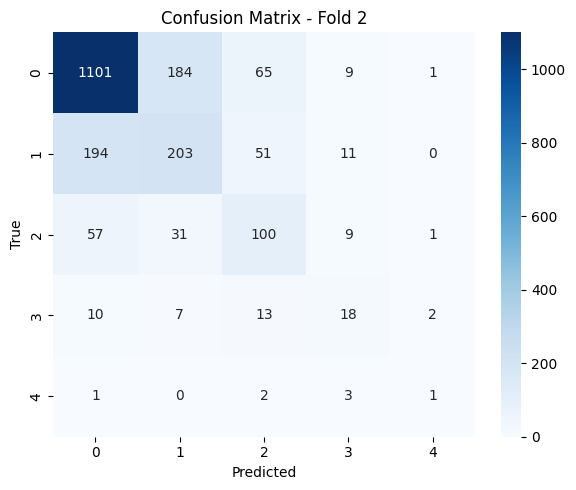

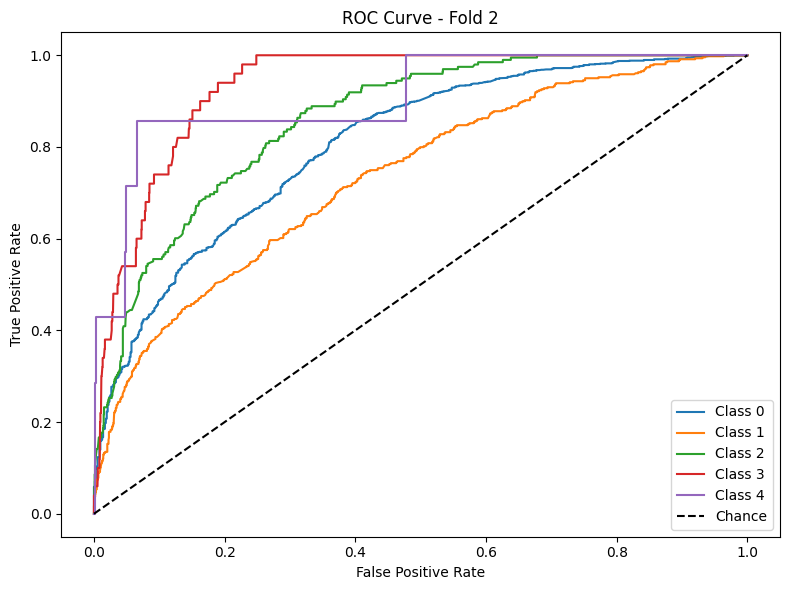

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13610
[LightGBM] [Info] Number of data points in the train set: 24063, number of used features: 68
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -2.348201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

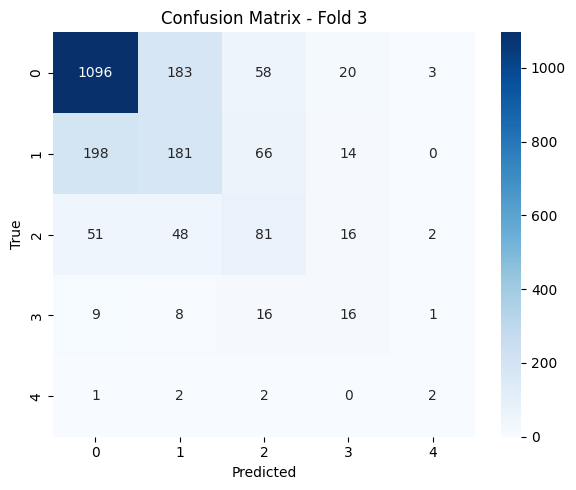

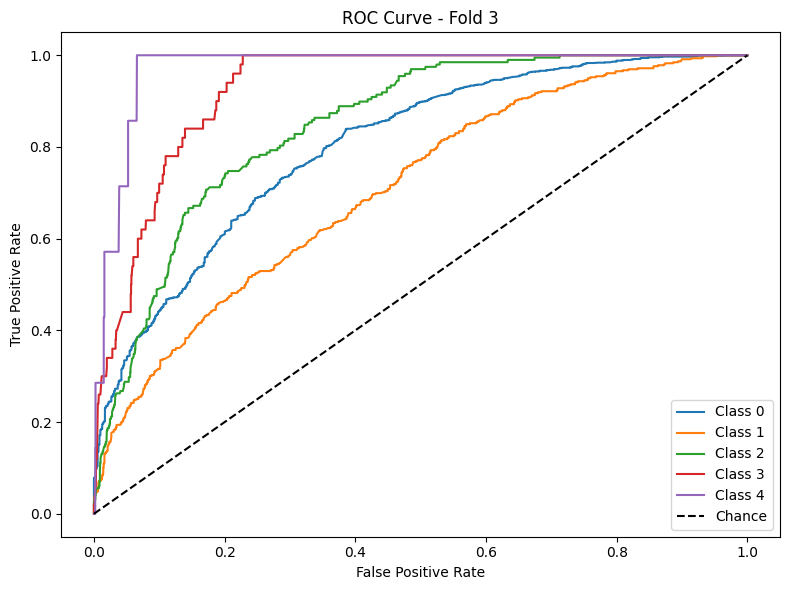

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13834
[LightGBM] [Info] Number of data points in the train set: 24063, number of used features: 68
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -2.348201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

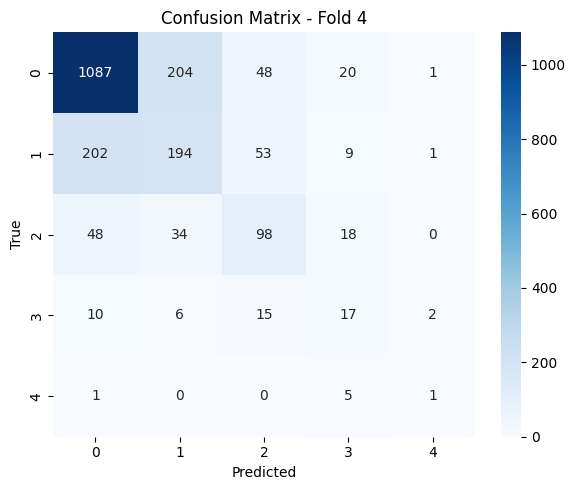

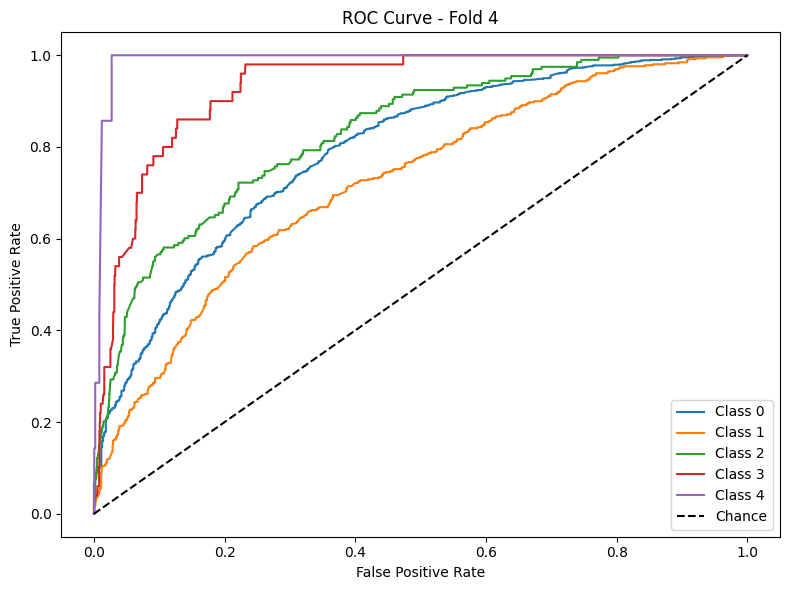

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14054
[LightGBM] [Info] Number of data points in the train set: 24063, number of used features: 68
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -2.348201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

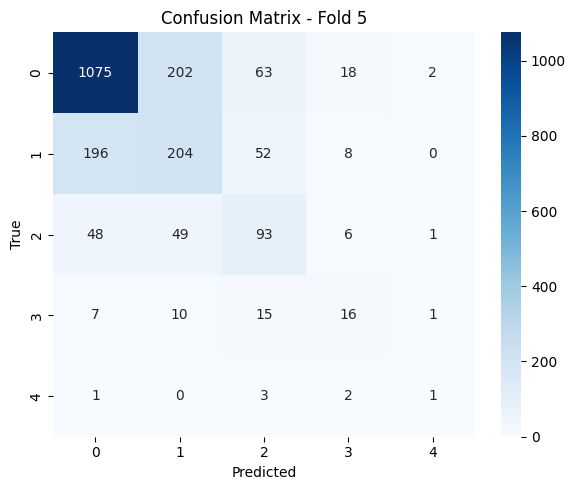

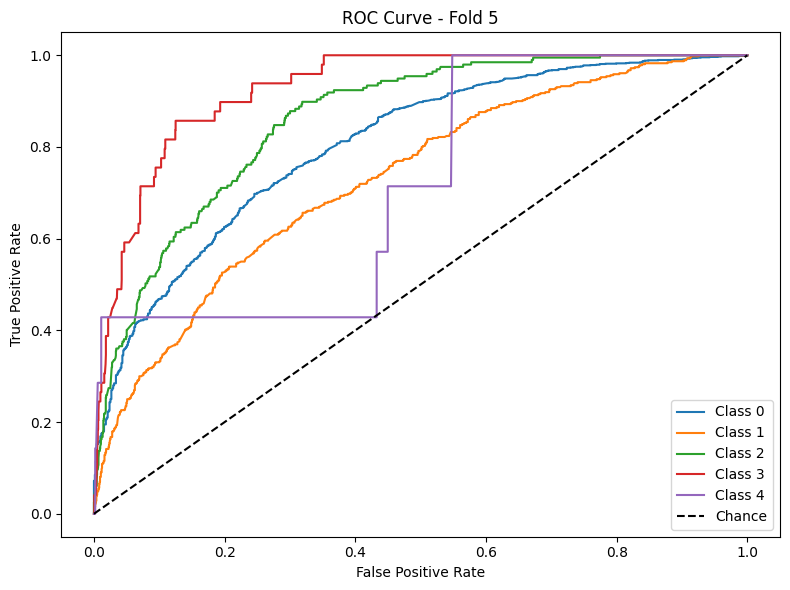


Average Accuracy: 0.6773
Average F1 Macro: 0.4435
Average AUC: 0.8447

Top Feature Importances:
remaining_time        35069
cluster               18826
total_words_phase1     8793
school                 6202
degree                 6184
eigenvector            5308
user_month             3879
total_neutral1         3415
closeness              3330
total_words_phase3     2693
dtype: int32

=== Training Phase 4 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

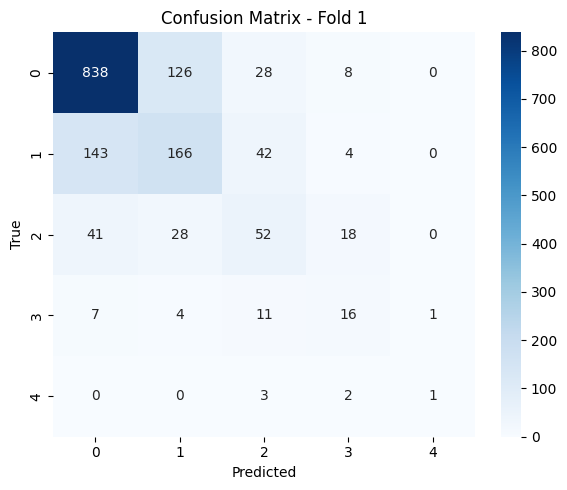

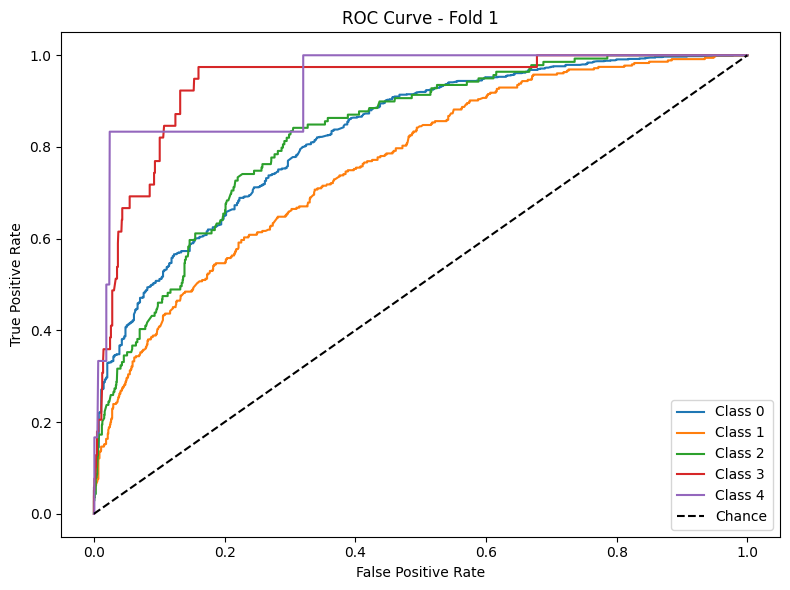

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15967
[LightGBM] [Info] Number of data points in the train set: 17679, number of used features: 84
[LightGBM] [Info] Start training from score -1.486833
[LightGBM] [Info] Start training from score -1.486833
[LightGBM] [Info] Start training from score -1.486833
[LightGBM] [Info] Start training from score -1.486833
[LightGBM] [Info] Start training from score -2.347057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

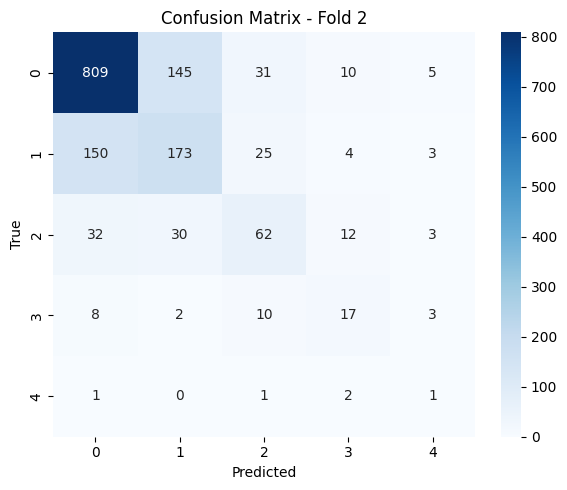

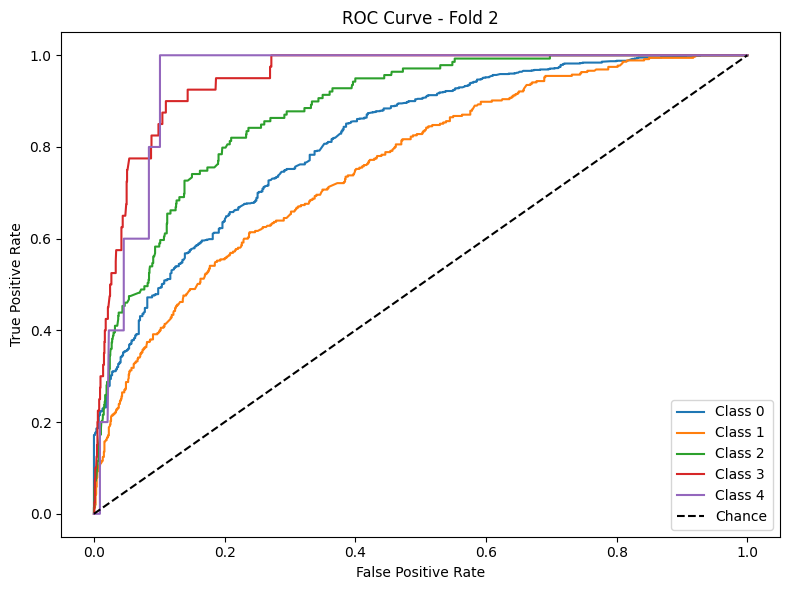

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16934
[LightGBM] [Info] Number of data points in the train set: 17683, number of used features: 83
[LightGBM] [Info] Start training from score -1.486809
[LightGBM] [Info] Start training from score -1.486809
[LightGBM] [Info] Start training from score -1.486809
[LightGBM] [Info] Start training from score -1.486809
[LightGBM] [Info] Start training from score -2.347284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

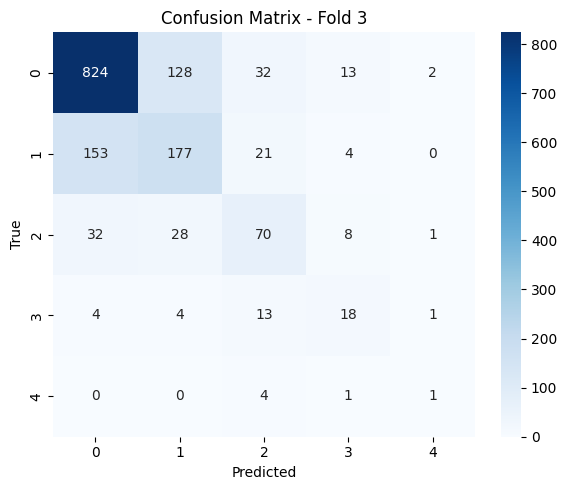

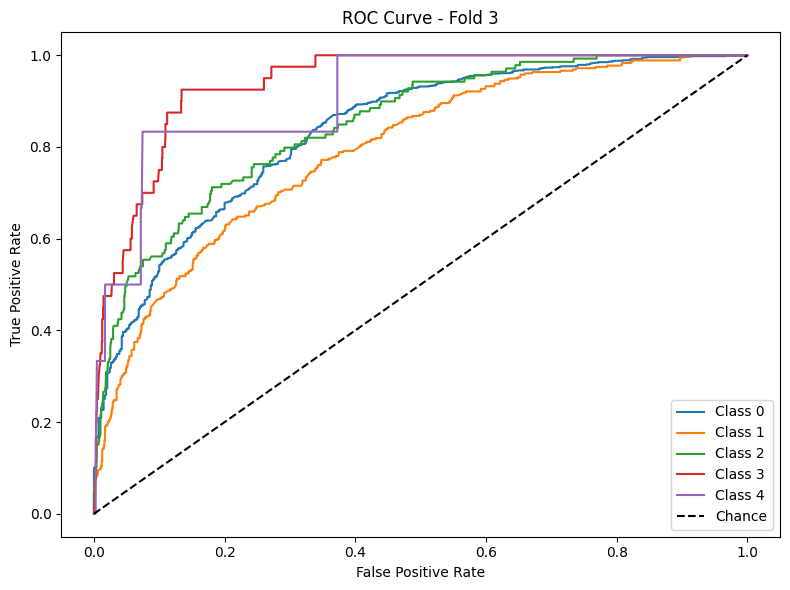

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16625
[LightGBM] [Info] Number of data points in the train set: 17683, number of used features: 83
[LightGBM] [Info] Start training from score -1.486809
[LightGBM] [Info] Start training from score -1.486809
[LightGBM] [Info] Start training from score -1.486809
[LightGBM] [Info] Start training from score -1.486809
[LightGBM] [Info] Start training from score -2.347284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.84      0.83       999
           1       0.53      0.47      0.50       356
           2       0.44      0.46      0.45       138
           3       0.34      0.38      0.36        3

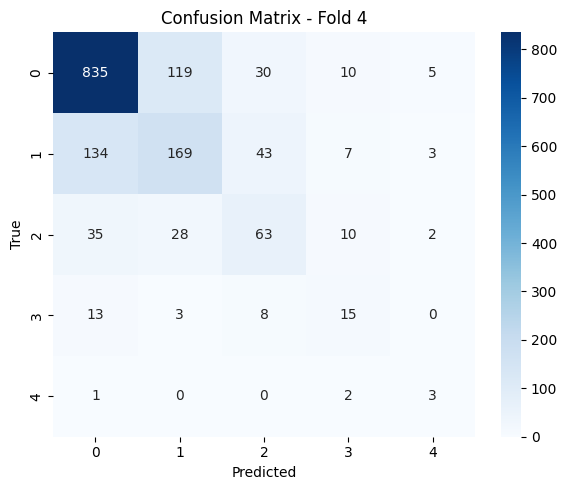

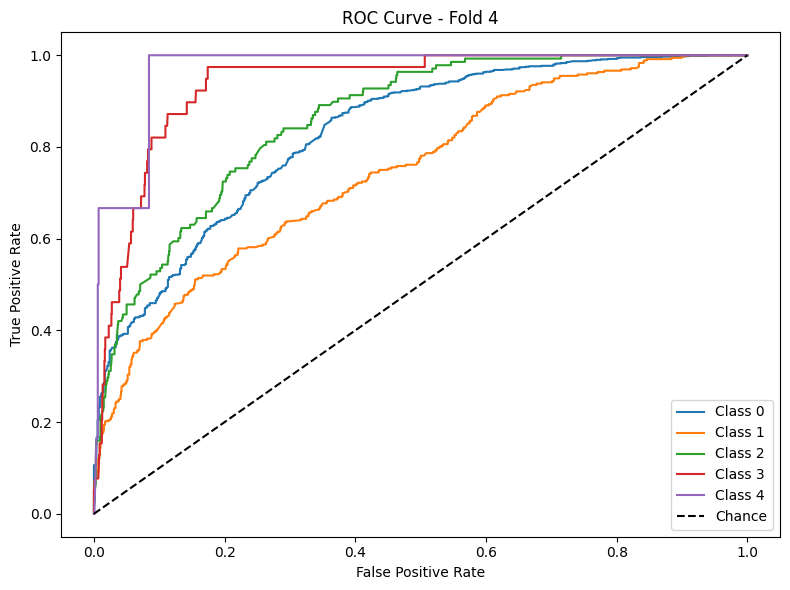

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13872
[LightGBM] [Info] Number of data points in the train set: 15985, number of used features: 83
[LightGBM] [Info] Start training from score -1.385857
[LightGBM] [Info] Start training from score -1.385857
[LightGBM] [Info] Start training from score -1.385857
[LightGBM] [Info] Start training from score -1.938742
[LightGBM] [Info] Start training from score -2.246331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

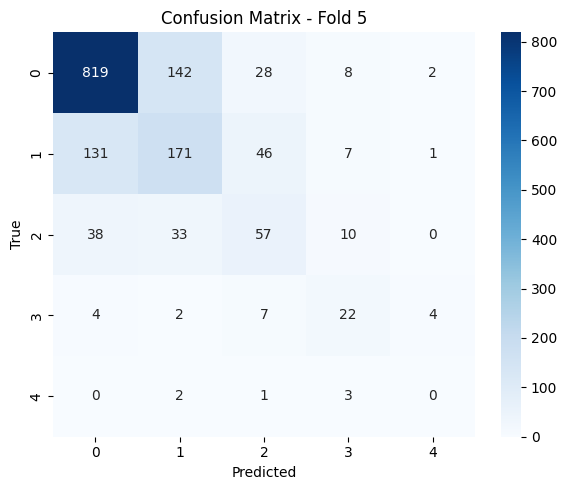

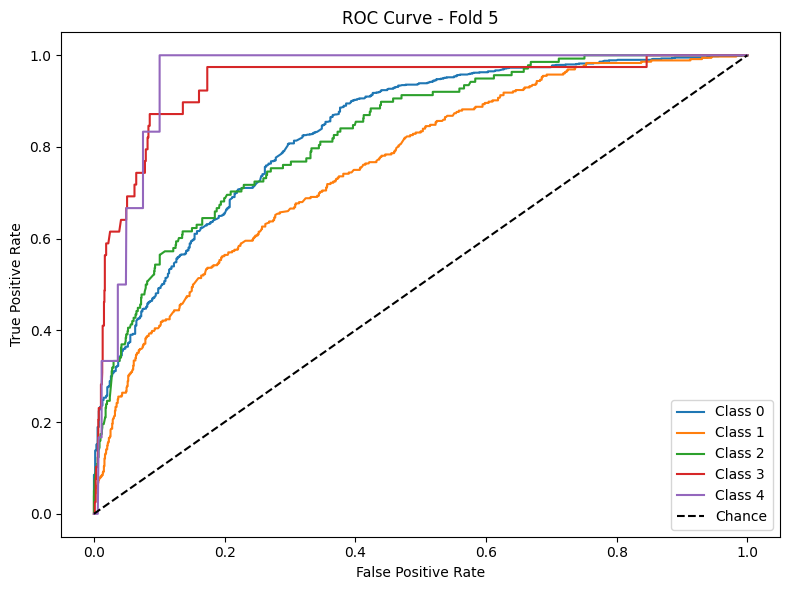


Average Accuracy: 0.6992
Average F1 Macro: 0.4673
Average AUC: 0.8649

Top Feature Importances:
remaining_time        21383
cluster               13563
school                 9744
total_words_phase1     8695
degree                 6711
eigenvector            6347
total_neutral1         4981
total_words_phase4     4061
user_month             3357
closeness              2891
dtype: int32


In [8]:
phase_paths = [f"/kaggle/input/smotesvm-train-enrich-data/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n=== Training Phase {i} ===")
    sample = True
    model, scaler, best_fold, metrics = train_phase(phase_path, param_dist, sample = sample)
    # Save best model & scaler
    if sample: 
        temp = "sample"
    else: temp = "no_sample"
    joblib.dump(model, f"best_model_{temp}_phase{i}.pkl")
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
    results[f"phase{i}"] = metrics



Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       568
           1       0.46      0.29      0.35        63
           2       0.42      0.33      0.37        43
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         9

    accuracy                           0.83       698
   macro avg       0.35      0.31      0.33       698
weighted avg       0.78      0.83      0.80       698



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


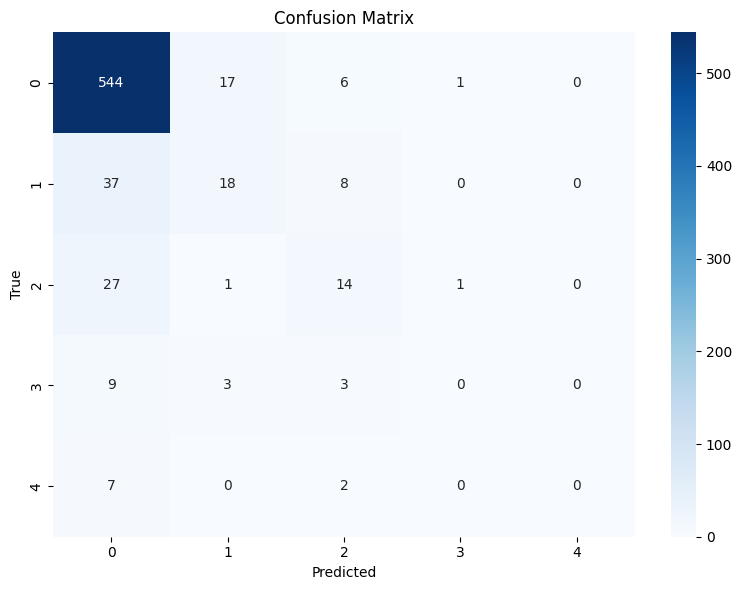


Test AUC (macro-average, OVR): 0.8398


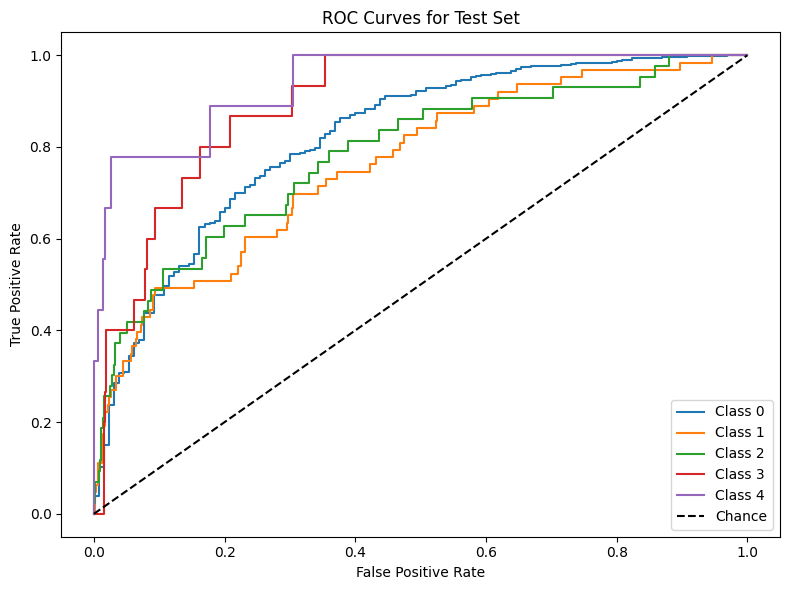


Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       544
           1       0.31      0.39      0.34        59
           2       0.37      0.31      0.34        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9

    accuracy                           0.80       668
   macro avg       0.32      0.32      0.32       668
weighted avg       0.78      0.80      0.79       668



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


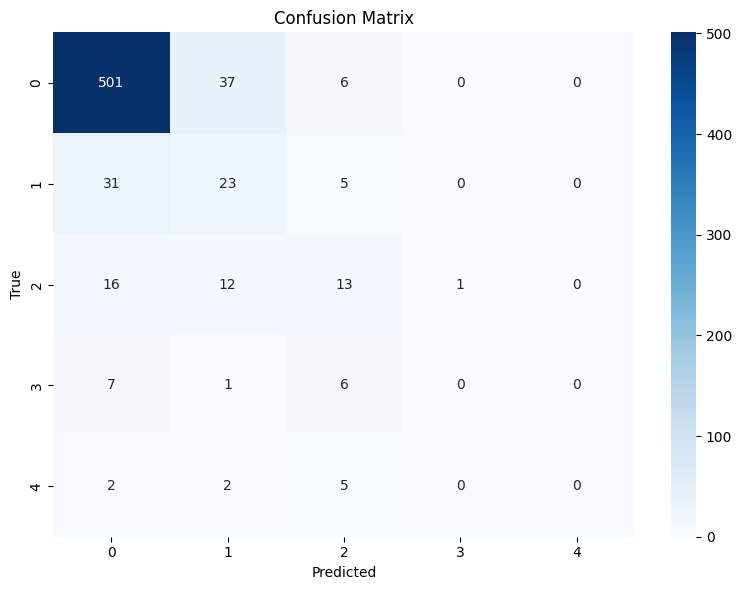


Test AUC (macro-average, OVR): 0.8540


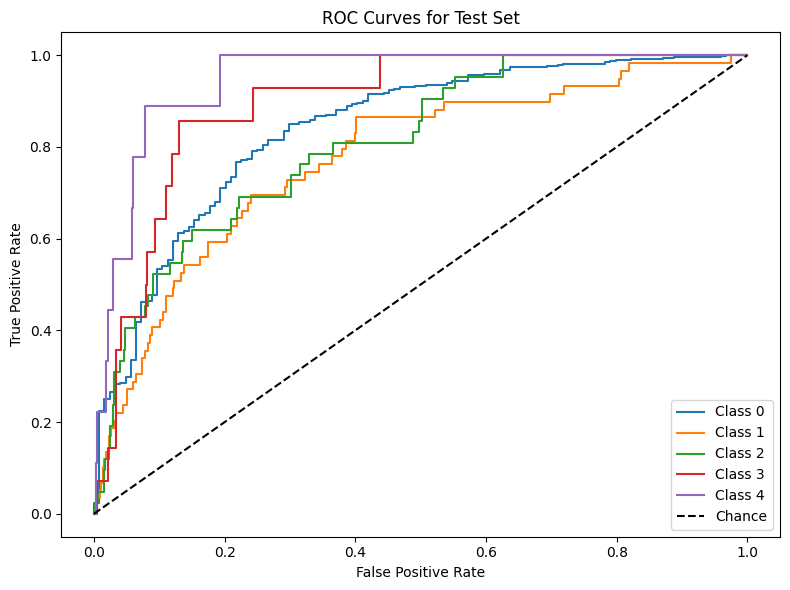


Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.97      0.91       455
           1       0.36      0.17      0.23        52
           2       0.19      0.10      0.13        29
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.82       554
   macro avg       0.28      0.25      0.26       554
weighted avg       0.75      0.82      0.78       554



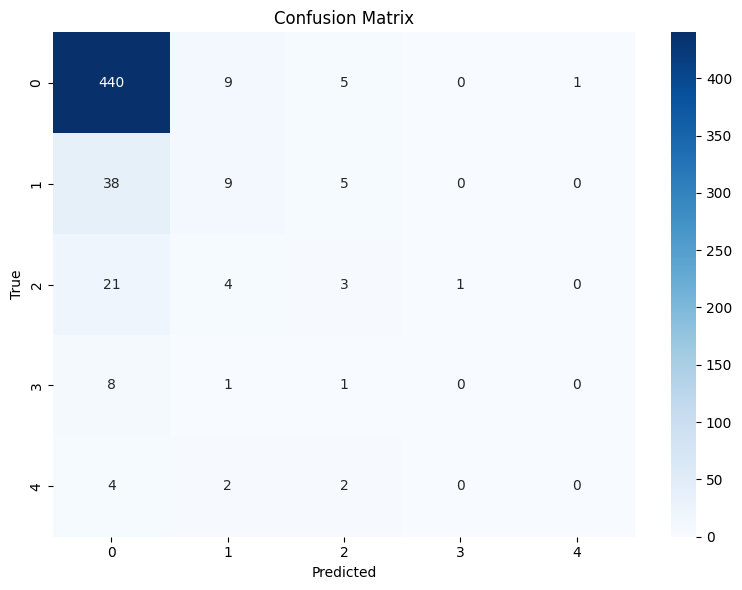


Test AUC (macro-average, OVR): 0.7788


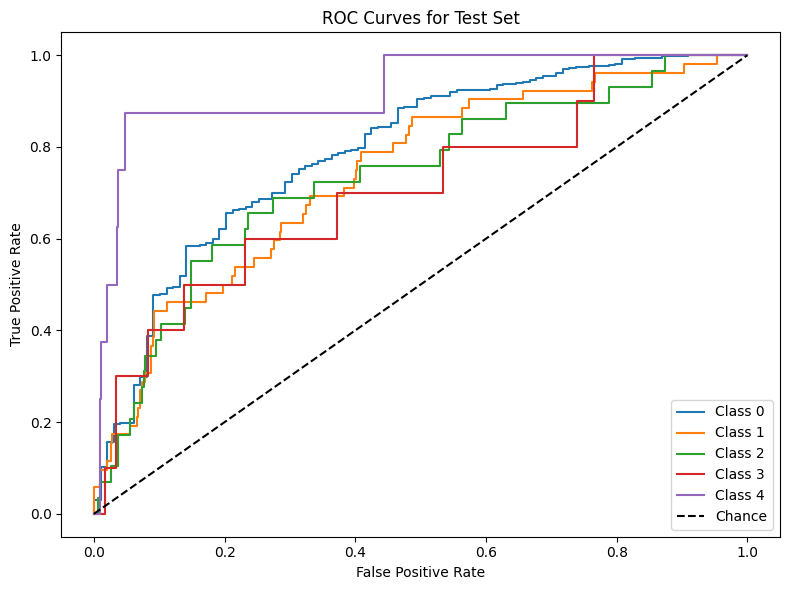


Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       395
           1       0.17      0.17      0.17        40
           2       0.19      0.25      0.21        24
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.79       477
   macro avg       0.25      0.27      0.26       477
weighted avg       0.77      0.79      0.78       477



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


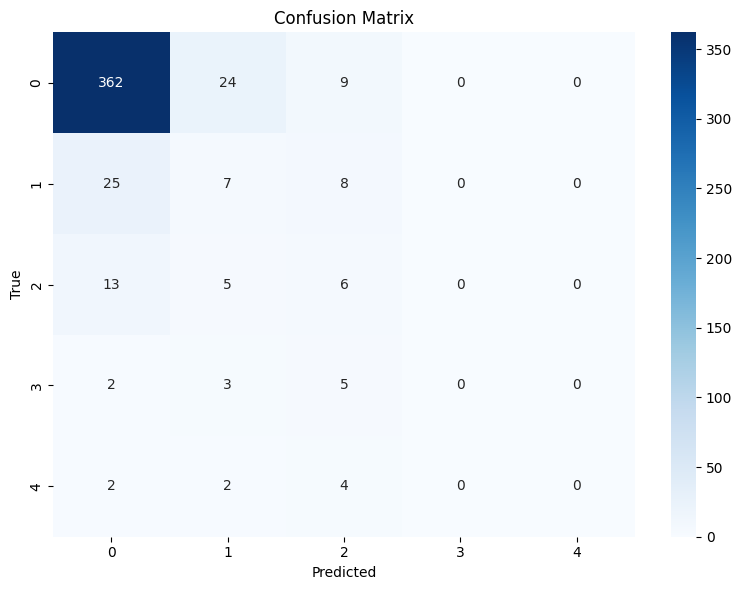


Test AUC (macro-average, OVR): 0.7959


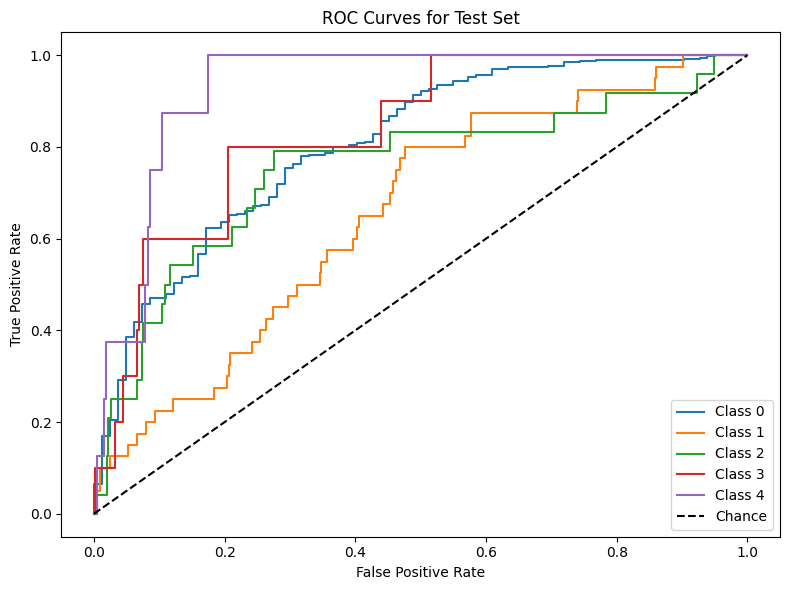

In [9]:
import glob

for i in range(1, 5):
    test_dir = f'/kaggle/input/enrich-data-node-clustering/phase{i}/user_train_phase_{i}_test.csv'
    
    # Get model and scaler using glob
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.pkl'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    # School mapping path
    school_mapping_file = f'/kaggle/input/smotesvm-train-enrich-data/outputs/phase{i}/mappings/school_mapping.pkl'

    # Predict on test set
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)
